# Baseline Quantitative Trading Pipeline

## Research Objective

**The purpose of this baseline is to serve as a control experiment against which all future features and modeling ideas are evaluated via incremental improvement.**

This document implements a minimal, interpretable, stable, reproducible, and economically sensible trading pipeline. The goal is not to maximize performance but to build a clean measurement instrument.

---

### What This Baseline Explicitly Excludes

| Category | Exclusion |
|----------|----------|
| Complexity | Regime logic, meta-learning, ensembling |
| Weighting | Asset-specific weights, signal confidence weighting |
| Advanced Methods | Statistical arbitrage, graph methods, deep learning |
| Classification | Hit-ratio optimization, probability calibration |

---

### Pipeline Structure

1. Data Loading and Preparation
2. Problem Formulation (Cross-Sectional Target)
3. Feature Engineering (3 Features)
4. Model Training (Ridge Regression)
5. Signal Construction (Dollar-Neutral)
6. Portfolio Construction (Long-Short)
7. Backtesting Engine
8. Performance Evaluation
9. Diagnostic Analysis
10. Conclusions

---

## 1. Environment Setup and Data Loading

In [6]:
!pip install scikit-learn

  Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# =============================================================================
# IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
np.random.seed(42)

# =============================================================================
# GLOBAL PARAMETERS
# =============================================================================
PARAMS = {
    # Feature Parameters
    'short_momentum_window': 5,      # Days for short-term momentum
    'medium_momentum_window': 20,    # Days for medium-term momentum
    'volatility_window': 20,         # Days for volatility estimation
    
    # Model Parameters
    'ridge_alpha': 1.0,              # Fixed regularization (no tuning)
    'training_window': 252,          # 1 year rolling window
    
    # Portfolio Parameters
    'long_pct': 0.20,                # Top 20% long
    'short_pct': 0.20,               # Bottom 20% short
    'target_volatility': 0.10,       # 10% annualized target vol
    
    # Backtest Parameters
    'transaction_cost_bps': 10,      # 10 bps per turnover
    'trading_days_per_year': 252,
}

print("Baseline Pipeline Parameters:")
print("=" * 50)
for k, v in PARAMS.items():
    print(f"  {k}: {v}")

Baseline Pipeline Parameters:
  short_momentum_window: 5
  medium_momentum_window: 20
  volatility_window: 20
  ridge_alpha: 1.0
  training_window: 252
  long_pct: 0.2
  short_pct: 0.2
  target_volatility: 0.1
  transaction_cost_bps: 10
  trading_days_per_year: 252


In [12]:
# =============================================================================
# DATA LOADING
# =============================================================================
df = pd.read_parquet('../data/processed/df_after_eda.parquet')

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of Assets: {df['asset_id'].nunique()}")    
print(f"Number of Trading Days: {df['Date'].nunique()}")

# Verify data completeness
pivot_check = df.pivot(index='Date', columns='asset_id', values='Close')
missing_pct = pivot_check.isnull().sum().sum() / pivot_check.size * 100
print(f"Missing Data: {missing_pct:.2f}%")

Dataset Shape: (251100, 10)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'asset_id', 'year', 'returns', 'log_returns']
Date Range: 2016-01-25 00:00:00 to 2026-01-16 00:00:00
Number of Assets: 100
Number of Trading Days: 2511
Missing Data: 0.00%


---

## 2. Problem Formulation

### 2.1 Why Cross-Sectional Relative Returns?

We do **not** predict raw returns. Instead, we define the target as cross-sectional relative performance:

$$y_{i,t+1} = r_{i,t+1} - \frac{1}{N_t} \sum_{j=1}^{N_t} r_{j,t+1}$$

**Rationale:**

1. **Heavy-tail robustness**: Market-wide moves are removed, reducing tail risk from systematic shocks
2. **Alignment with long-short portfolios**: A long-short portfolio's return is exactly the spread between winners and losers
3. **Cross-sectional interpretability**: Features predict relative rank, not absolute magnitude
4. **Stationarity**: Cross-sectional targets are more stationary than raw returns

In [14]:
# =============================================================================
# CREATE PANEL DATA STRUCTURE
# =============================================================================

def create_panel_data(df):
    """
    Create wide-format panel data for returns.
    Returns dictionary of DataFrames indexed by Date with asset_id columns.
    """
    panel = {}
    
    # Pivot each variable
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        panel[col] = df.pivot(index='Date', columns='asset_id', values=col)
    
    # Calculate daily returns (close-to-close)
    panel['returns'] = panel['Close'].pct_change()
    
    # Calculate forward returns (what we're trying to predict)
    panel['forward_returns'] = panel['returns'].shift(-1)
    
    return panel

panel = create_panel_data(df)

print(f"Panel Structure:")
print(f"  Shape: {panel['returns'].shape}")
print(f"  Date Index: {panel['returns'].index[0]} to {panel['returns'].index[-1]}")
print(f"  Assets: {panel['returns'].columns.tolist()[:5]} ... ({len(panel['returns'].columns)} total)")

Panel Structure:
  Shape: (2511, 100)
  Date Index: 2016-01-25 00:00:00 to 2026-01-16 00:00:00
  Assets: ['Asset_001', 'Asset_002', 'Asset_003', 'Asset_004', 'Asset_005'] ... (100 total)


In [15]:
# =============================================================================
# DEFINE CROSS-SECTIONAL TARGET
# =============================================================================

def compute_cross_sectional_target(returns_df):
    """
    Compute cross-sectional relative return:
    y_{i,t} = r_{i,t} - mean(r_{j,t}) for all j
    
    This removes the market component and focuses on relative performance.
    """
    # Cross-sectional mean for each day
    cs_mean = returns_df.mean(axis=1)
    
    # Subtract cross-sectional mean from each asset
    relative_returns = returns_df.sub(cs_mean, axis=0)
    
    return relative_returns

# Compute target (forward relative returns)
panel['target'] = compute_cross_sectional_target(panel['forward_returns'])

# Verify: cross-sectional mean should be ~0 for each day
cs_mean_check = panel['target'].mean(axis=1)
print(f"Cross-sectional mean of target (should be ~0):")
print(f"  Mean: {cs_mean_check.mean():.2e}")
print(f"  Std:  {cs_mean_check.std():.2e}")
print(f"  Max:  {cs_mean_check.abs().max():.2e}")

Cross-sectional mean of target (should be ~0):
  Mean: 2.47e-20
  Std:  1.50e-18
  Max:  2.11e-17


---

## 3. Feature Engineering (Baseline)

We use exactly **3 features**, each satisfying:
- Scale-free
- Risk-aware
- Economically interpretable

### Feature Definitions

**Feature 1: Short-Term Volatility-Normalized Momentum**
$$f_1(i,t) = \frac{\sum_{k=1}^{5} r_{i,t-k}}{\sigma_{i,t}^{20}}$$

**Feature 2: Medium-Term Cumulative Return**
$$f_2(i,t) = \sum_{k=1}^{20} r_{i,t-k}$$

**Feature 3: Recent Realized Volatility**
$$f_3(i,t) = \sigma_{i,t}^{20}$$

### Rationale

| Feature | Economic Interpretation |
|---------|------------------------|
| $f_1$ | Risk-adjusted short-term momentum; captures recent price direction normalized by risk |
| $f_2$ | Raw medium-term trend; captures whether asset has been winning or losing |
| $f_3$ | Volatility level; high-vol assets may behave differently cross-sectionally |

In [16]:
# =============================================================================
# FEATURE CONSTRUCTION
# =============================================================================

def compute_baseline_features(panel, params):
    """
    Compute the 3 baseline features:
    1. Short-term volatility-normalized momentum
    2. Medium-term cumulative return
    3. Recent realized volatility
    
    All features are computed using ONLY past data (no lookahead).
    """
    returns = panel['returns']
    
    features = {}
    
    # -------------------------------------------------------------------------
    # Feature 1: Short-Term Volatility-Normalized Momentum
    # f1(i,t) = sum(r_{i,t-k}, k=1..5) / sigma_{i,t}^{20}
    # -------------------------------------------------------------------------
    short_window = params['short_momentum_window']
    vol_window = params['volatility_window']
    
    # Rolling sum of returns (shifted to avoid lookahead)
    short_momentum = returns.shift(1).rolling(window=short_window).sum()
    
    # Rolling volatility (shifted to avoid lookahead)
    rolling_vol = returns.shift(1).rolling(window=vol_window).std()
    
    # Normalized momentum
    features['f1_short_mom_norm'] = short_momentum / rolling_vol
    
    # -------------------------------------------------------------------------
    # Feature 2: Medium-Term Cumulative Return
    # f2(i,t) = sum(r_{i,t-k}, k=1..20)
    # -------------------------------------------------------------------------
    medium_window = params['medium_momentum_window']
    features['f2_medium_mom'] = returns.shift(1).rolling(window=medium_window).sum()
    
    # -------------------------------------------------------------------------
    # Feature 3: Recent Realized Volatility
    # f3(i,t) = sigma_{i,t}^{20}
    # -------------------------------------------------------------------------
    features['f3_volatility'] = rolling_vol
    
    return features

features = compute_baseline_features(panel, PARAMS)

print("Features Computed:")
for name, feat in features.items():
    valid_count = feat.notna().sum().sum()
    print(f"  {name}: {valid_count:,} valid observations")

Features Computed:
  f1_short_mom_norm: 249,000 valid observations
  f2_medium_mom: 249,000 valid observations
  f3_volatility: 249,000 valid observations


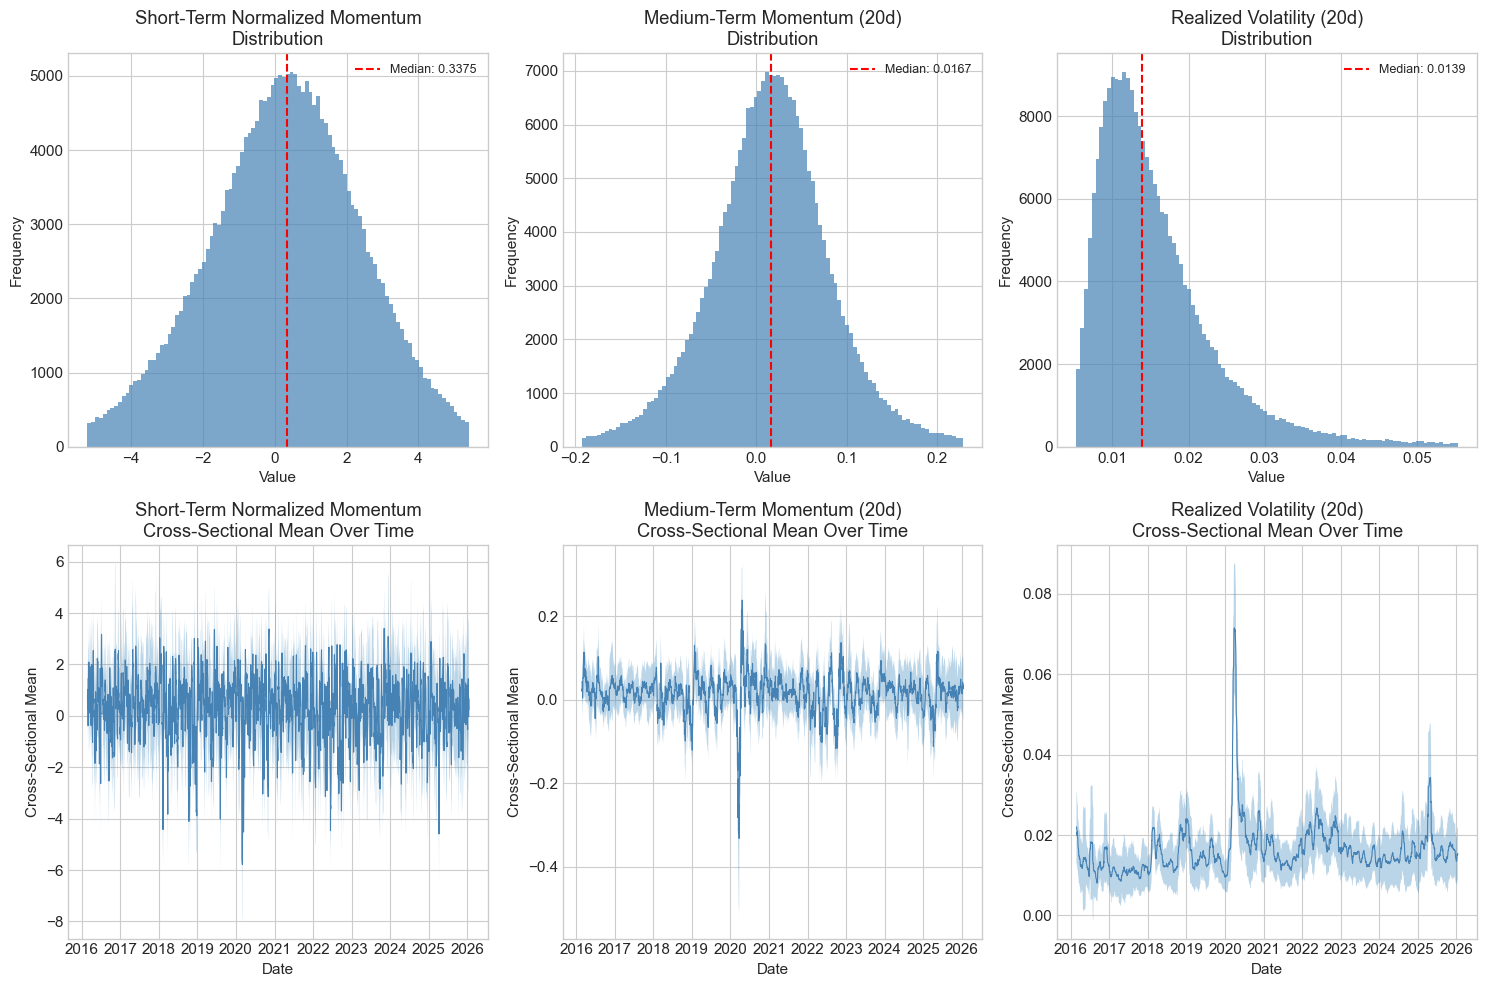


Feature Summary Statistics (pooled across assets and time):

Short-Term Normalized Momentum:
  Mean:   0.287702
  Std:    2.231723
  Median: 0.337467
  5%:     -3.518699
  95%:    3.902110

Medium-Term Momentum (20d):
  Mean:   0.015928
  Std:    0.078742
  Median: 0.016739
  5%:     -0.104034
  95%:    0.134449

Realized Volatility (20d):
  Mean:   0.016274
  Std:    0.009688
  Median: 0.013884
  5%:     0.006933
  95%:    0.033168


In [17]:
# =============================================================================
# FEATURE STATISTICS AND VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

feature_names = ['f1_short_mom_norm', 'f2_medium_mom', 'f3_volatility']
feature_labels = [
    'Short-Term Normalized Momentum',
    'Medium-Term Momentum (20d)',
    'Realized Volatility (20d)'
]

for i, (fname, flabel) in enumerate(zip(feature_names, feature_labels)):
    feat = features[fname]
    
    # Distribution
    ax = axes[0, i]
    feat_flat = feat.values.flatten()
    feat_flat = feat_flat[~np.isnan(feat_flat)]
    
    # Clip for visualization
    clip_low, clip_high = np.percentile(feat_flat, [1, 99])
    feat_clipped = feat_flat[(feat_flat >= clip_low) & (feat_flat <= clip_high)]
    
    ax.hist(feat_clipped, bins=100, alpha=0.7, color='steelblue', edgecolor='none')
    ax.axvline(np.median(feat_clipped), color='red', linestyle='--', label=f'Median: {np.median(feat_clipped):.4f}')
    ax.set_title(f'{flabel}\nDistribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=9)
    
    # Time series of cross-sectional mean
    ax = axes[1, i]
    cs_mean = feat.mean(axis=1)
    cs_std = feat.std(axis=1)
    ax.plot(cs_mean.index, cs_mean, color='steelblue', linewidth=0.8)
    ax.fill_between(cs_mean.index, cs_mean - cs_std, cs_mean + cs_std, alpha=0.3)
    ax.set_title(f'{flabel}\nCross-Sectional Mean Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cross-Sectional Mean')

plt.tight_layout()
plt.savefig('../outputs/figures/baseline/01_feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nFeature Summary Statistics (pooled across assets and time):")
print("=" * 70)
for fname, flabel in zip(feature_names, feature_labels):
    feat_flat = features[fname].values.flatten()
    feat_flat = feat_flat[~np.isnan(feat_flat)]
    print(f"\n{flabel}:")
    print(f"  Mean:   {np.mean(feat_flat):.6f}")
    print(f"  Std:    {np.std(feat_flat):.6f}")
    print(f"  Median: {np.median(feat_flat):.6f}")
    print(f"  5%:     {np.percentile(feat_flat, 5):.6f}")
    print(f"  95%:    {np.percentile(feat_flat, 95):.6f}")

In [18]:
# =============================================================================
# FEATURE-TARGET CORRELATION (SANITY CHECK)
# =============================================================================

def compute_feature_target_correlation(features, target):
    """
    Compute pooled correlation between each feature and the target.
    This is a basic sanity check - we expect weak but non-zero correlation.
    """
    results = {}
    
    for fname, feat in features.items():
        # Align feature and target
        common_idx = feat.index.intersection(target.index)
        feat_aligned = feat.loc[common_idx]
        target_aligned = target.loc[common_idx]
        
        # Flatten and remove NaN
        f_flat = feat_aligned.values.flatten()
        t_flat = target_aligned.values.flatten()
        
        valid_mask = ~(np.isnan(f_flat) | np.isnan(t_flat))
        f_valid = f_flat[valid_mask]
        t_valid = t_flat[valid_mask]
        
        # Compute correlation
        corr, pval = stats.pearsonr(f_valid, t_valid)
        rank_corr, rank_pval = stats.spearmanr(f_valid, t_valid)
        
        results[fname] = {
            'pearson_corr': corr,
            'pearson_pval': pval,
            'spearman_corr': rank_corr,
            'spearman_pval': rank_pval,
            'n_obs': len(f_valid)
        }
    
    return results

corr_results = compute_feature_target_correlation(features, panel['target'])

print("Feature-Target Correlations (Pooled):")
print("=" * 70)
print(f"{'Feature':<25} {'Pearson':>10} {'p-value':>12} {'Spearman':>10} {'N':>12}")
print("-" * 70)
for fname, res in corr_results.items():
    print(f"{fname:<25} {res['pearson_corr']:>10.4f} {res['pearson_pval']:>12.2e} {res['spearman_corr']:>10.4f} {res['n_obs']:>12,}")

print("\nInterpretation:")
print("  - Correlations are expected to be weak (< 0.05 in absolute value)")
print("  - Statistical significance with large N does not imply economic significance")
print("  - The goal is not to find strong predictors, but to establish a baseline")

Feature-Target Correlations (Pooled):
Feature                      Pearson      p-value   Spearman            N
----------------------------------------------------------------------
f1_short_mom_norm            -0.0035     7.90e-02    -0.0031      248,900
f2_medium_mom                -0.0052     9.23e-03    -0.0059      248,900
f3_volatility                 0.0137     9.06e-12     0.0047      248,900

Interpretation:
  - Correlations are expected to be weak (< 0.05 in absolute value)
  - Statistical significance with large N does not imply economic significance
  - The goal is not to find strong predictors, but to establish a baseline


---

## 4. Cross-Sectional Feature Standardization

Before modeling, we standardize features **cross-sectionally** at each time $t$:

$$\tilde{f}_k(i,t) = \frac{f_k(i,t) - \mu_k(t)}{\sigma_k(t)}$$

where $\mu_k(t)$ and $\sigma_k(t)$ are the cross-sectional mean and standard deviation of feature $k$ at time $t$.

**Rationale:**
- Ensures features have comparable scale across assets
- Removes time-varying level shifts in features
- Makes regression coefficients interpretable as "per standard deviation" effects

In [19]:
# =============================================================================
# CROSS-SECTIONAL STANDARDIZATION
# =============================================================================

def cross_sectional_standardize(feature_df):
    """
    Standardize feature cross-sectionally at each time t.
    
    f_tilde(i,t) = (f(i,t) - mean_j(f(j,t))) / std_j(f(j,t))
    """
    cs_mean = feature_df.mean(axis=1)
    cs_std = feature_df.std(axis=1)
    
    # Avoid division by zero
    cs_std = cs_std.replace(0, np.nan)
    
    standardized = feature_df.sub(cs_mean, axis=0).div(cs_std, axis=0)
    
    return standardized

# Standardize all features
features_std = {}
for fname, feat in features.items():
    features_std[fname] = cross_sectional_standardize(feat)

# Verify standardization
print("Verification of Cross-Sectional Standardization:")
print("=" * 50)
for fname in features_std:
    cs_mean = features_std[fname].mean(axis=1)
    cs_std = features_std[fname].std(axis=1)
    print(f"\n{fname}:")
    print(f"  Cross-sectional mean (should be ~0): {cs_mean.mean():.6f}")
    print(f"  Cross-sectional std (should be ~1):  {cs_std.mean():.6f}")

Verification of Cross-Sectional Standardization:

f1_short_mom_norm:
  Cross-sectional mean (should be ~0): -0.000000
  Cross-sectional std (should be ~1):  1.000000

f2_medium_mom:
  Cross-sectional mean (should be ~0): -0.000000
  Cross-sectional std (should be ~1):  1.000000

f3_volatility:
  Cross-sectional mean (should be ~0): -0.000000
  Cross-sectional std (should be ~1):  1.000000


---

## 5. Model Training: Rolling Ridge Regression

### Model Specification

We use **Ridge Regression** with a single fixed regularization parameter:

$$\hat{\beta} = \arg\min_\beta \left\{ \sum_{t \in \text{train}} \sum_{i=1}^{N_t} (y_{i,t} - X_{i,t}^\top \beta)^2 + \alpha ||\beta||_2^2 \right\}$$

### Training Protocol

1. **Rolling window**: Train on past 252 days (1 year)
2. **Cross-sectional training**: Pool all assets in training window
3. **Fixed regularization**: $\alpha = 1.0$ (no hyperparameter tuning)
4. **Daily retraining**: Model is re-estimated each day

### Why Ridge Regression?

- Simple and interpretable
- L2 regularization prevents coefficient explosion
- Closed-form solution ensures reproducibility
- No hyperparameter search reduces overfitting risk

In [20]:
# =============================================================================
# PREPARE DATA FOR MODELING
# =============================================================================

def prepare_model_data(features_std, target, dates):
    """
    Prepare aligned feature matrix X and target vector y for a given set of dates.
    Returns stacked cross-sectional data.
    """
    feature_names = list(features_std.keys())
    
    X_list = []
    y_list = []
    
    for date in dates:
        if date not in target.index:
            continue
            
        # Get features for this date
        X_row = pd.DataFrame({fname: features_std[fname].loc[date] for fname in feature_names})
        y_row = target.loc[date]
        
        # Align and remove NaN
        valid_mask = X_row.notna().all(axis=1) & y_row.notna()
        
        if valid_mask.sum() > 0:
            X_list.append(X_row[valid_mask])
            y_list.append(y_row[valid_mask])
    
    if len(X_list) == 0:
        return None, None
    
    X = pd.concat(X_list)
    y = pd.concat(y_list)
    
    return X, y

# Test data preparation
test_dates = panel['returns'].index[300:310]
X_test, y_test = prepare_model_data(features_std, panel['target'], test_dates)
print(f"Test data preparation:")
print(f"  X shape: {X_test.shape}")
print(f"  y shape: {y_test.shape}")

Test data preparation:
  X shape: (1000, 3)
  y shape: (1000,)


In [21]:
# =============================================================================
# ROLLING RIDGE REGRESSION
# =============================================================================

def run_rolling_regression(features_std, target, params):
    """
    Run rolling Ridge regression to generate predictions.
    
    For each day t:
    1. Train on [t - training_window, t - 1]
    2. Predict for day t
    
    Returns:
    - predictions: DataFrame of predictions aligned with target
    - coefficients: DataFrame of rolling coefficients
    """
    training_window = params['training_window']
    ridge_alpha = params['ridge_alpha']
    
    all_dates = target.index
    feature_names = list(features_std.keys())
    assets = target.columns
    
    # Initialize output containers
    predictions = pd.DataFrame(index=all_dates, columns=assets, dtype=float)
    coefficients = pd.DataFrame(index=all_dates, columns=['intercept'] + feature_names, dtype=float)
    
    # Rolling regression
    start_idx = training_window + 50  # Allow warmup for features
    
    print(f"Running rolling regression from index {start_idx} to {len(all_dates)}...")
    print(f"  Training window: {training_window} days")
    print(f"  Ridge alpha: {ridge_alpha}")
    
    for t_idx in range(start_idx, len(all_dates)):
        if t_idx % 250 == 0:
            print(f"  Processing day {t_idx}/{len(all_dates)} ({all_dates[t_idx].date()})...")
        
        current_date = all_dates[t_idx]
        
        # Training dates: [t - training_window, t - 1]
        train_dates = all_dates[t_idx - training_window:t_idx]
        
        # Prepare training data
        X_train, y_train = prepare_model_data(features_std, target, train_dates)
        
        if X_train is None or len(X_train) < 100:
            continue
        
        # Fit Ridge regression
        model = Ridge(alpha=ridge_alpha, fit_intercept=True)
        model.fit(X_train, y_train)
        
        # Store coefficients
        coefficients.loc[current_date, 'intercept'] = model.intercept_
        coefficients.loc[current_date, feature_names] = model.coef_
        
        # Predict for current date
        X_pred = pd.DataFrame({fname: features_std[fname].loc[current_date] for fname in feature_names})
        valid_mask = X_pred.notna().all(axis=1)
        
        if valid_mask.sum() > 0:
            X_pred_valid = X_pred[valid_mask]
            y_pred = model.predict(X_pred_valid)
            predictions.loc[current_date, X_pred_valid.index] = y_pred
    
    # Drop rows with all NaN
    predictions = predictions.dropna(how='all')
    coefficients = coefficients.dropna(how='all')
    
    print(f"\nCompleted. Predictions shape: {predictions.shape}")
    
    return predictions, coefficients

predictions, coefficients = run_rolling_regression(features_std, panel['target'], PARAMS)

Running rolling regression from index 302 to 2511...
  Training window: 252 days
  Ridge alpha: 1.0
  Processing day 500/2511 (2018-01-18)...
  Processing day 750/2511 (2019-01-16)...
  Processing day 1000/2511 (2020-01-14)...
  Processing day 1250/2511 (2021-01-11)...
  Processing day 1500/2511 (2022-01-06)...
  Processing day 1750/2511 (2023-01-05)...
  Processing day 2000/2511 (2024-01-04)...
  Processing day 2250/2511 (2025-01-02)...
  Processing day 2500/2511 (2026-01-02)...

Completed. Predictions shape: (2209, 100)


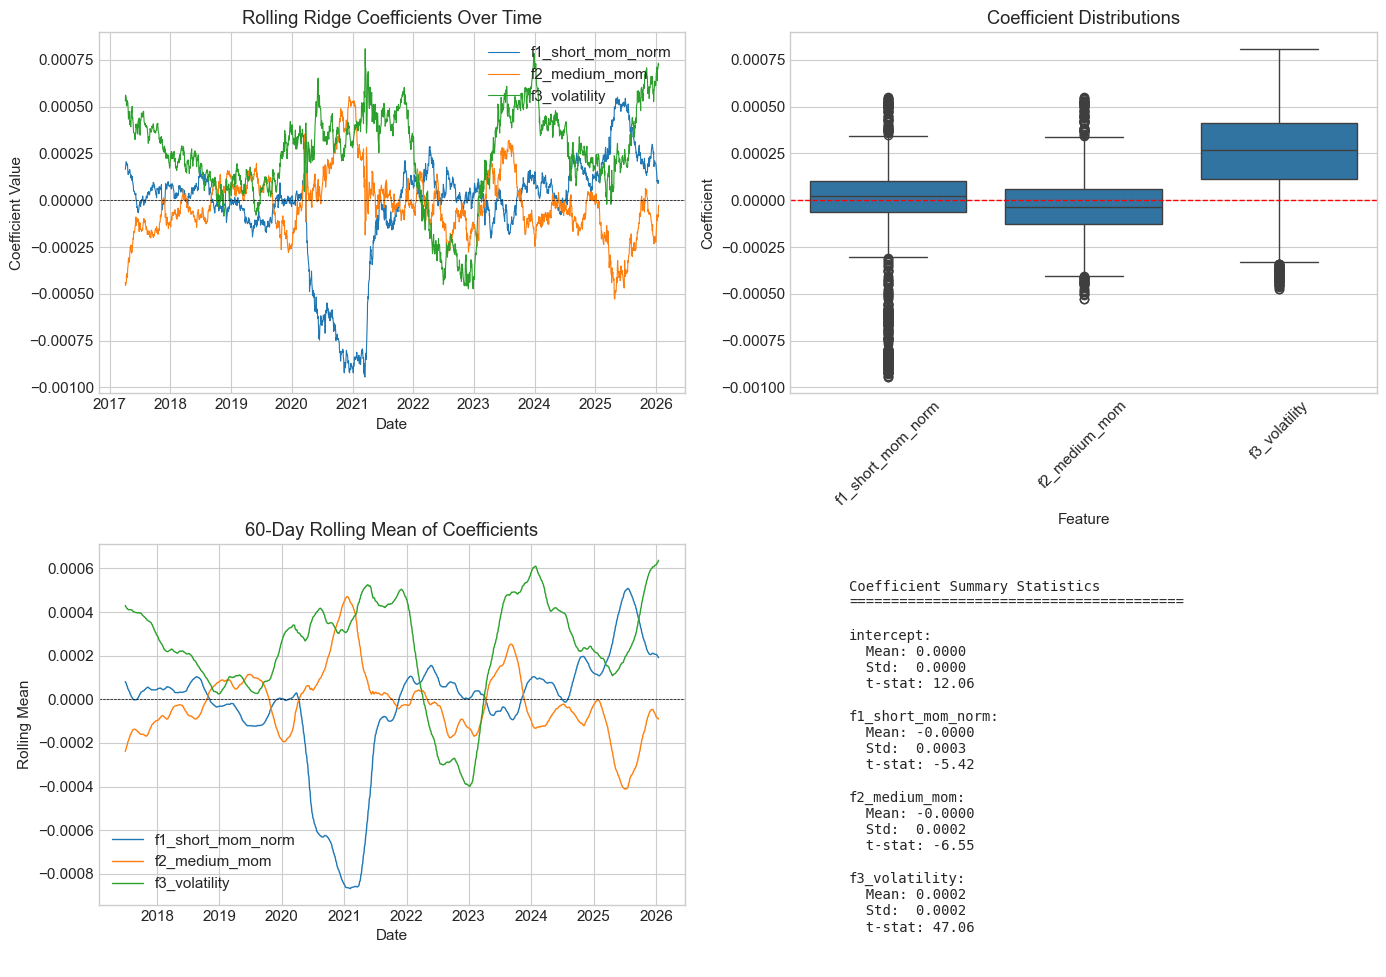


Coefficient Statistics:
       intercept  f1_short_mom_norm  f2_medium_mom  f3_volatility
count     2209.0          2209.0000      2209.0000      2209.0000
mean         0.0            -0.0000        -0.0000         0.0002
std          0.0             0.0003         0.0002         0.0002
min         -0.0            -0.0009        -0.0005        -0.0005
25%         -0.0            -0.0001        -0.0001         0.0001
50%          0.0             0.0000        -0.0000         0.0003
75%          0.0             0.0001         0.0001         0.0004
max          0.0             0.0006         0.0006         0.0008


In [22]:
# =============================================================================
# COEFFICIENT ANALYSIS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot rolling coefficients
ax = axes[0, 0]
for col in coefficients.columns:
    if col != 'intercept':
        ax.plot(coefficients.index, coefficients[col], label=col, linewidth=0.8)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_title('Rolling Ridge Coefficients Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Coefficient Value')
ax.legend(loc='upper right')

# Coefficient distributions
ax = axes[0, 1]
coef_data = coefficients.drop(columns='intercept').melt(var_name='Feature', value_name='Coefficient')
sns.boxplot(data=coef_data, x='Feature', y='Coefficient', ax=ax)
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_title('Coefficient Distributions')
ax.tick_params(axis='x', rotation=45)

# Rolling coefficient means (60-day)
ax = axes[1, 0]
for col in coefficients.columns:
    if col != 'intercept':
        rolling_mean = coefficients[col].rolling(60).mean()
        ax.plot(rolling_mean.index, rolling_mean, label=col, linewidth=1)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_title('60-Day Rolling Mean of Coefficients')
ax.set_xlabel('Date')
ax.set_ylabel('Rolling Mean')
ax.legend()

# Coefficient summary
ax = axes[1, 1]
ax.axis('off')
summary_text = "Coefficient Summary Statistics\n" + "=" * 40 + "\n\n"
for col in coefficients.columns:
    vals = coefficients[col].dropna()
    summary_text += f"{col}:\n"
    summary_text += f"  Mean: {vals.mean():.4f}\n"
    summary_text += f"  Std:  {vals.std():.4f}\n"
    summary_text += f"  t-stat: {vals.mean() / (vals.std() / np.sqrt(len(vals))):.2f}\n\n"
ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.savefig('../outputs/figures/baseline/02_coefficient_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print coefficient statistics
print("\nCoefficient Statistics:")
print(coefficients.describe().round(4))

---

## 5.1 Understanding the Walk-Forward Training Scheme

### What Data Does the Model Train On?

The model uses a **rolling walk-forward** approach - there is no fixed train/test split:

| Component | Description |
|-----------|-------------|
| **Training Window** | 252 days (1 year) of rolling historical data |
| **Prediction Day** | Each day `t`, model trained on `[t-252, t-1]`, predicts for `t` |
| **Start of Predictions** | Day 302 (252 training + 50 warmup for features) |
| **Backtest Period** | ~Early 2017 to end of 2025 (~8+ years) |

### Key Insight: Every Prediction is Out-of-Sample

Unlike traditional ML train/test splits, walk-forward ensures:
- **No look-ahead bias**: Model only sees past data at time of prediction
- **Regime adaptation**: Model continuously updates with recent data  
- **Realistic simulation**: Mirrors how you'd actually trade

In [44]:
# =============================================================================
# VISUALIZE TRAINING DATA SPLIT
# =============================================================================

# Show the walk-forward scheme visually
all_dates = panel['returns'].index
start_idx = PARAMS['training_window'] + 50  # 302

print("=" * 70)
print("WALK-FORWARD TRAINING SCHEME")
print("=" * 70)
print(f"\nDataset: {all_dates[0].date()} to {all_dates[-1].date()} ({len(all_dates)} trading days)")
print(f"\nWarmup period (features need history):")
print(f"  Days 0-49: Feature computation warmup")
print(f"\nRolling Training Window: {PARAMS['training_window']} days")
print(f"Predictions start at day: {start_idx} ({all_dates[start_idx].date()})")
print(f"Predictions end at day: {len(all_dates)-1} ({all_dates[-1].date()})")
print(f"\nTotal prediction days (backtest period): {len(all_dates) - start_idx}")

# Show a few example training windows
print("\n" + "=" * 70)
print("EXAMPLE TRAINING WINDOWS")
print("=" * 70)
example_days = [start_idx, start_idx + 252, start_idx + 504, len(all_dates) - 1]
for day_idx in example_days:
    if day_idx >= len(all_dates):
        continue
    pred_date = all_dates[day_idx]
    train_start = all_dates[day_idx - PARAMS['training_window']]
    train_end = all_dates[day_idx - 1]
    print(f"\nPrediction Date: {pred_date.date()}")
    print(f"  Training on: {train_start.date()} to {train_end.date()}")
    print(f"  Training window: {PARAMS['training_window']} days")
    print(f"  Model has NEVER seen data on or after {pred_date.date()}")

WALK-FORWARD TRAINING SCHEME

Dataset: 2016-01-25 to 2026-01-16 (2511 trading days)

Warmup period (features need history):
  Days 0-49: Feature computation warmup

Rolling Training Window: 252 days
Predictions start at day: 302 (2017-04-05)
Predictions end at day: 2510 (2026-01-16)

Total prediction days (backtest period): 2209

EXAMPLE TRAINING WINDOWS

Prediction Date: 2017-04-05
  Training on: 2016-04-06 to 2017-04-04
  Training window: 252 days
  Model has NEVER seen data on or after 2017-04-05

Prediction Date: 2018-04-06
  Training on: 2017-04-05 to 2018-04-05
  Training window: 252 days
  Model has NEVER seen data on or after 2018-04-06

Prediction Date: 2019-04-08
  Training on: 2018-04-06 to 2019-04-05
  Training window: 252 days
  Model has NEVER seen data on or after 2019-04-08

Prediction Date: 2026-01-16
  Training on: 2025-01-15 to 2026-01-15
  Training window: 252 days
  Model has NEVER seen data on or after 2026-01-16


### Inside the Black Box: Signal Construction on a Single Day

Let's pick a random day and trace through the **entire pipeline** from raw data to final portfolio positions. This demystifies how:

1. **Features** are computed for each asset
2. **Ridge regression** produces a raw prediction (alpha signal)
3. **Cross-sectional ranking** converts predictions to signals
4. **Portfolio construction** converts signals to positions (weights)

In [45]:
# =============================================================================
# INSIDE THE BLACK BOX: SINGLE DAY WALKTHROUGH
# =============================================================================

# Pick a random day from the middle of the backtest
np.random.seed(123)
valid_pred_dates = predictions.dropna(how='all').index
sample_date = np.random.choice(valid_pred_dates[len(valid_pred_dates)//3:2*len(valid_pred_dates)//3])
sample_date = pd.Timestamp(sample_date)

print("=" * 80)
print(f"SIGNAL CONSTRUCTION WALKTHROUGH: {sample_date.date()}")
print("=" * 80)

# Step 1: Show raw features for this day
print("\n" + "-" * 80)
print("STEP 1: Raw Features for All Assets")
print("-" * 80)
feature_data = pd.DataFrame({
    'f1_short_mom_norm': features['f1_short_mom_norm'].loc[sample_date],
    'f2_medium_mom': features['f2_medium_mom'].loc[sample_date],
    'f3_volatility': features['f3_volatility'].loc[sample_date]
})
print(f"Raw feature values (first 10 assets):\n{feature_data.head(10).round(4)}")
print(f"\nFeature stats across {len(feature_data)} assets:")
print(feature_data.describe().round(4))

# Step 2: Cross-sectionally standardized features
print("\n" + "-" * 80)
print("STEP 2: Cross-Sectionally Standardized Features (z-scores)")
print("-" * 80)
std_feature_data = pd.DataFrame({
    'f1_std': features_std['f1_short_mom_norm'].loc[sample_date],
    'f2_std': features_std['f2_medium_mom'].loc[sample_date],
    'f3_std': features_std['f3_volatility'].loc[sample_date]
})
print(f"Standardized features (first 10 assets):\n{std_feature_data.head(10).round(4)}")
print(f"\nVerification - mean should be 0, std should be 1:")
print(f"  Means: {std_feature_data.mean().round(6).tolist()}")
print(f"  Stds:  {std_feature_data.std().round(6).tolist()}")

SIGNAL CONSTRUCTION WALKTHROUGH: 2022-03-17

--------------------------------------------------------------------------------
STEP 1: Raw Features for All Assets
--------------------------------------------------------------------------------
Raw feature values (first 10 assets):
           f1_short_mom_norm  f2_medium_mom  f3_volatility
asset_id                                                  
Asset_001            -0.9096        -0.0752         0.0208
Asset_002             0.8634        -0.0125         0.0250
Asset_003             0.0008        -0.0146         0.0244
Asset_004             3.3374        -0.0139         0.0293
Asset_005             1.5131        -0.0588         0.0452
Asset_006             0.8848        -0.0718         0.0323
Asset_007            -0.4225        -0.0767         0.0416
Asset_008             2.4804         0.0628         0.0131
Asset_009             4.0422         0.1274         0.0126
Asset_010             2.6678        -0.0677         0.0224

Feature st

In [46]:
# Step 3: Model coefficients for this day
print("\n" + "-" * 80)
print("STEP 3: Ridge Regression Coefficients (trained on past 252 days)")
print("-" * 80)
day_coefs = coefficients.loc[sample_date]
print(f"Intercept: {day_coefs['intercept']:.6f}")
print(f"f1 (short mom) coefficient: {day_coefs['f1_short_mom_norm']:.6f}")
print(f"f2 (medium mom) coefficient: {day_coefs['f2_medium_mom']:.6f}")
print(f"f3 (volatility) coefficient: {day_coefs['f3_volatility']:.6f}")

print("\nInterpretation:")
if day_coefs['f1_short_mom_norm'] > 0:
    print(f"  - Positive f1 coef: Model favors high short-term momentum (momentum)")
else:
    print(f"  - Negative f1 coef: Model favors low short-term momentum (reversal)")
if day_coefs['f3_volatility'] > 0:
    print(f"  - Positive f3 coef: Model favors high volatility stocks")
else:
    print(f"  - Negative f3 coef: Model favors low volatility stocks")

# Step 4: Raw predictions
print("\n" + "-" * 80)
print("STEP 4: Raw Model Predictions (expected relative return)")
print("-" * 80)
day_predictions = predictions.loc[sample_date].dropna()
print(f"Raw predictions for {len(day_predictions)} assets:")
print(f"  Min: {day_predictions.min():.6f}")
print(f"  Max: {day_predictions.max():.6f}")
print(f"  Mean: {day_predictions.mean():.6f}")
print(f"  Std: {day_predictions.std():.6f}")

# Show formula
print("\nPrediction formula: ŷ = intercept + β1*f1 + β2*f2 + β3*f3")
example_asset = day_predictions.index[0]
manual_pred = (day_coefs['intercept'] + 
               day_coefs['f1_short_mom_norm'] * std_feature_data.loc[example_asset, 'f1_std'] +
               day_coefs['f2_medium_mom'] * std_feature_data.loc[example_asset, 'f2_std'] +
               day_coefs['f3_volatility'] * std_feature_data.loc[example_asset, 'f3_std'])
print(f"\nVerification for {example_asset}:")
print(f"  Manual calculation: {manual_pred:.6f}")
print(f"  Model prediction: {day_predictions[example_asset]:.6f}")


--------------------------------------------------------------------------------
STEP 3: Ridge Regression Coefficients (trained on past 252 days)
--------------------------------------------------------------------------------
Intercept: 0.000000
f1 (short mom) coefficient: 0.000177
f2 (medium mom) coefficient: -0.000108
f3 (volatility) coefficient: -0.000046

Interpretation:
  - Positive f1 coef: Model favors high short-term momentum (momentum)
  - Negative f3 coef: Model favors low volatility stocks

--------------------------------------------------------------------------------
STEP 4: Raw Model Predictions (expected relative return)
--------------------------------------------------------------------------------
Raw predictions for 100 assets:
  Min: -0.000663
  Max: 0.000529
  Mean: 0.000000
  Std: 0.000187

Prediction formula: ŷ = intercept + β1*f1 + β2*f2 + β3*f3

Verification for Asset_001:
  Manual calculation: -0.000139
  Model prediction: -0.000139


In [47]:
# Step 5: Signal (cross-sectional rank)
print("\n" + "-" * 80)
print("STEP 5: Signal Construction (predictions → signals)")
print("-" * 80)
day_signals = signals.loc[sample_date].dropna()
print(f"Signals are the RANK of predictions (standardized to mean=0, std=1)")
print(f"\nSignal distribution:")
print(f"  Min: {day_signals.min():.4f} (most bearish)")
print(f"  Max: {day_signals.max():.4f} (most bullish)")
print(f"  Mean: {day_signals.mean():.4f} (should be ~0)")

# Show top and bottom assets by signal
print(f"\nTop 5 assets (LONG candidates):")
top5 = day_signals.nlargest(5)
for asset, sig in top5.items():
    print(f"  {asset}: signal = {sig:.4f}")

print(f"\nBottom 5 assets (SHORT candidates):")
bot5 = day_signals.nsmallest(5)
for asset, sig in bot5.items():
    print(f"  {asset}: signal = {sig:.4f}")

# Step 6: Final portfolio weights
print("\n" + "-" * 80)
print("STEP 6: Portfolio Construction (signals → positions)")
print("-" * 80)
day_weights = weights.loc[sample_date].dropna()

long_mask = day_weights > 0
short_mask = day_weights < 0

print(f"Long-Short Portfolio (top/bottom {int(PARAMS['long_pct']*100)}%):")
print(f"  Long positions: {long_mask.sum()} assets")
print(f"  Short positions: {short_mask.sum()} assets")
print(f"  Total long exposure: {day_weights[long_mask].sum():.4f}")
print(f"  Total short exposure: {day_weights[short_mask].sum():.4f}")
print(f"  Net exposure (should be ~0): {day_weights.sum():.6f}")

print(f"\nIndividual weights (equal-weighted within long/short):")
if long_mask.sum() > 0:
    print(f"  Each long position: {day_weights[long_mask].iloc[0]:.4f}")
if short_mask.sum() > 0:
    print(f"  Each short position: {day_weights[short_mask].iloc[0]:.4f}")


--------------------------------------------------------------------------------
STEP 5: Signal Construction (predictions → signals)
--------------------------------------------------------------------------------
Signals are the RANK of predictions (standardized to mean=0, std=1)

Signal distribution:
  Min: -0.0007 (most bearish)
  Max: 0.0005 (most bullish)
  Mean: 0.0000 (should be ~0)

Top 5 assets (LONG candidates):
  Asset_085: signal = 0.0005
  Asset_030: signal = 0.0004
  Asset_010: signal = 0.0003
  Asset_023: signal = 0.0003
  Asset_095: signal = 0.0003

Bottom 5 assets (SHORT candidates):
  Asset_021: signal = -0.0007
  Asset_070: signal = -0.0006
  Asset_091: signal = -0.0005
  Asset_013: signal = -0.0005
  Asset_047: signal = -0.0003

--------------------------------------------------------------------------------
STEP 6: Portfolio Construction (signals → positions)
--------------------------------------------------------------------------------
Long-Short Portfolio (top

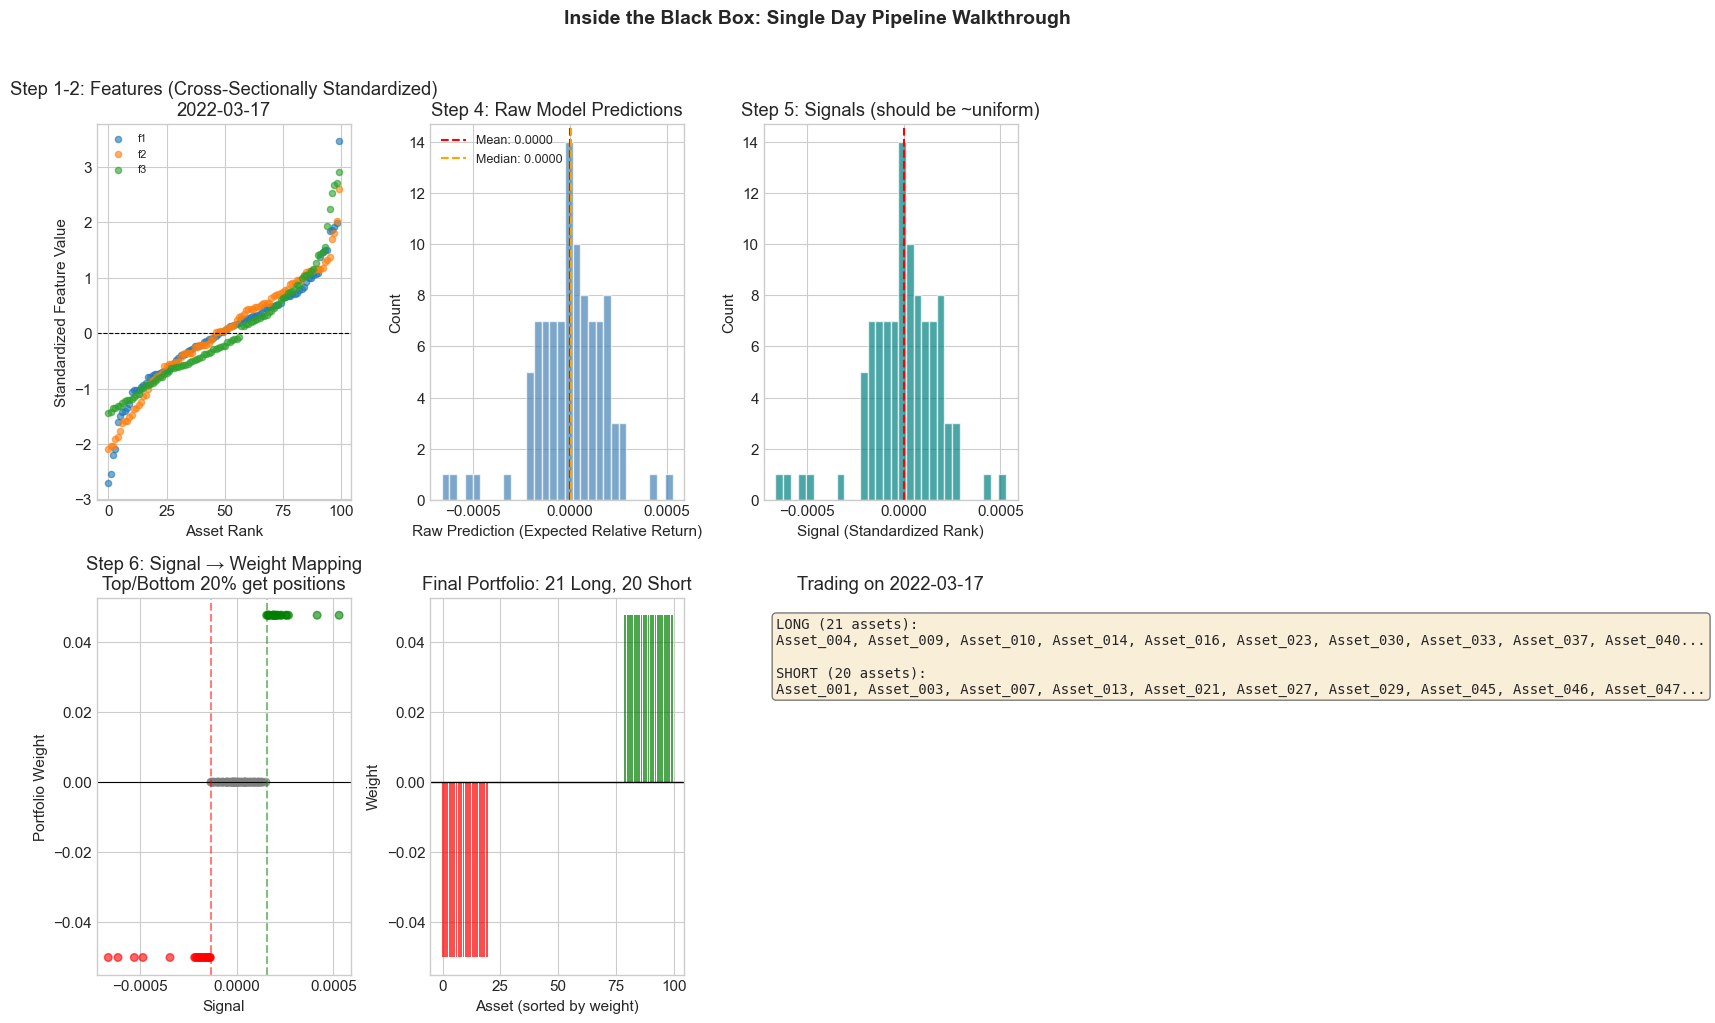

In [48]:
# =============================================================================
# VISUALIZATION: Single Day Pipeline
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Feature values for all assets
ax = axes[0, 0]
std_feature_data_plot = std_feature_data.dropna()
for i, col in enumerate(std_feature_data_plot.columns):
    ax.scatter(range(len(std_feature_data_plot)), std_feature_data_plot[col].sort_values(), 
               alpha=0.6, s=20, label=col.replace('_std', ''))
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Asset Rank')
ax.set_ylabel('Standardized Feature Value')
ax.set_title(f'Step 1-2: Features (Cross-Sectionally Standardized)\n{sample_date.date()}')
ax.legend(fontsize=8)

# 2. Prediction distribution
ax = axes[0, 1]
ax.hist(day_predictions.values, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
ax.axvline(day_predictions.mean(), color='red', linestyle='--', label=f'Mean: {day_predictions.mean():.4f}')
ax.axvline(day_predictions.median(), color='orange', linestyle='--', label=f'Median: {day_predictions.median():.4f}')
ax.set_xlabel('Raw Prediction (Expected Relative Return)')
ax.set_ylabel('Count')
ax.set_title('Step 4: Raw Model Predictions')
ax.legend(fontsize=9)

# 3. Signal distribution
ax = axes[0, 2]
ax.hist(day_signals.values, bins=30, color='teal', edgecolor='white', alpha=0.7)
ax.axvline(0, color='red', linestyle='--')
ax.set_xlabel('Signal (Standardized Rank)')
ax.set_ylabel('Count')
ax.set_title('Step 5: Signals (should be ~uniform)')

# 4. Signal to Weights mapping
ax = axes[1, 0]
merged = pd.DataFrame({'signal': day_signals, 'weight': day_weights}).dropna()
colors = ['green' if w > 0 else 'red' if w < 0 else 'gray' for w in merged['weight']]
ax.scatter(merged['signal'], merged['weight'], c=colors, alpha=0.6, s=30)
ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(merged['signal'].quantile(PARAMS['long_pct']), color='red', linestyle='--', alpha=0.5)
ax.axvline(merged['signal'].quantile(1-PARAMS['long_pct']), color='green', linestyle='--', alpha=0.5)
ax.set_xlabel('Signal')
ax.set_ylabel('Portfolio Weight')
ax.set_title(f'Step 6: Signal → Weight Mapping\nTop/Bottom {int(PARAMS["long_pct"]*100)}% get positions')

# 5. Final portfolio bar chart (sorted by weight)
ax = axes[1, 1]
sorted_weights = day_weights.sort_values()
colors = ['green' if w > 0 else 'red' for w in sorted_weights]
ax.bar(range(len(sorted_weights)), sorted_weights.values, color=colors, alpha=0.7)
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Asset (sorted by weight)')
ax.set_ylabel('Weight')
ax.set_title(f'Final Portfolio: {long_mask.sum()} Long, {short_mask.sum()} Short')

# 6. Which assets are we trading?
ax = axes[1, 2]
long_assets = day_weights[day_weights > 0].index.tolist()
short_assets = day_weights[day_weights < 0].index.tolist()
text = f"LONG ({len(long_assets)} assets):\n"
text += ", ".join(long_assets[:10])
if len(long_assets) > 10:
    text += f"..."
text += f"\n\nSHORT ({len(short_assets)} assets):\n"
text += ", ".join(short_assets[:10])
if len(short_assets) > 10:
    text += f"..."
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.axis('off')
ax.set_title(f'Trading on {sample_date.date()}')

plt.suptitle(f'Inside the Black Box: Single Day Pipeline Walkthrough', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/baseline/08_single_day_blackbox.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 6. Signal Construction

We convert raw predictions into dollar-neutral trading signals:

$$\alpha_{i,t} = \hat{y}_{i,t} - \frac{1}{N_t} \sum_{j=1}^{N_t} \hat{y}_{j,t}$$

This ensures:
$$\sum_{i=1}^{N_t} \alpha_{i,t} = 0$$

The signals are then converted to portfolio weights via ranking.

In [23]:
# =============================================================================
# SIGNAL CONSTRUCTION
# =============================================================================

def construct_signals(predictions):
    """
    Convert predictions to dollar-neutral signals.
    
    alpha_{i,t} = y_hat_{i,t} - mean_j(y_hat_{j,t})
    """
    # Cross-sectional demean
    cs_mean = predictions.mean(axis=1)
    signals = predictions.sub(cs_mean, axis=0)
    
    return signals

signals = construct_signals(predictions)

# Verify dollar neutrality
signal_sum = signals.sum(axis=1)
print("Dollar Neutrality Check:")
print(f"  Signal sum mean: {signal_sum.mean():.2e}")
print(f"  Signal sum std:  {signal_sum.std():.2e}")
print(f"  Signal sum max:  {signal_sum.abs().max():.2e}")

Dollar Neutrality Check:
  Signal sum mean: -1.17e-20
  Signal sum std:  1.46e-18
  Signal sum max:  1.02e-17


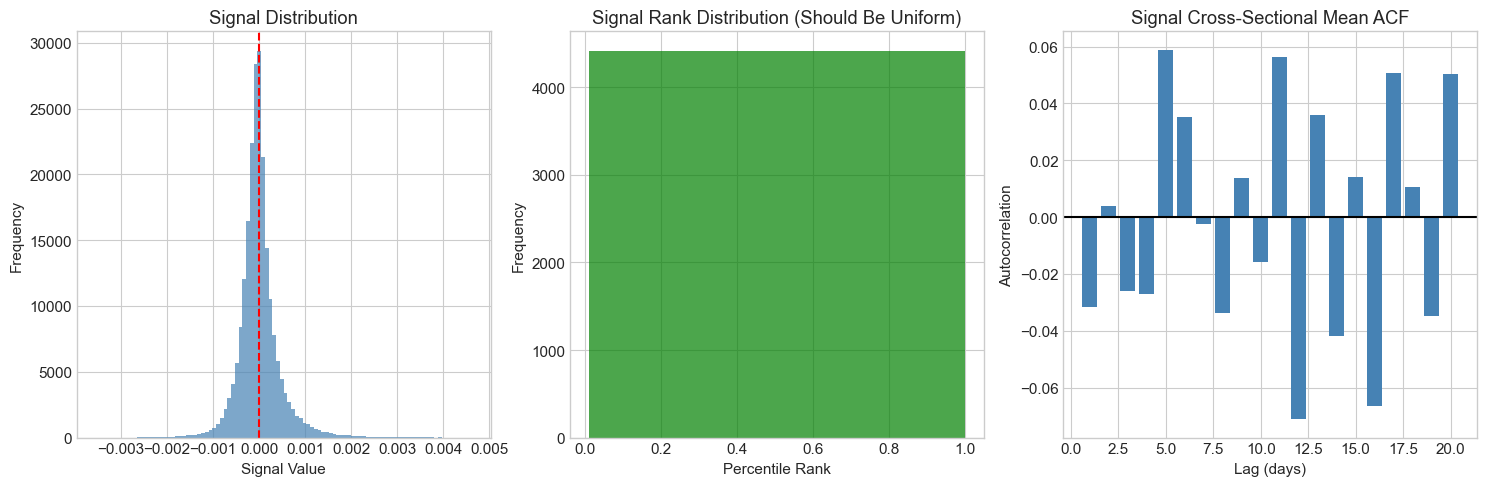

In [24]:
# =============================================================================
# CROSS-SECTIONAL RANKING
# =============================================================================

def compute_cross_sectional_ranks(signals):
    """
    Convert signals to cross-sectional percentile ranks.
    Rank 1 = lowest signal, Rank N = highest signal.
    Returns percentile rank in [0, 1].
    """
    ranks = signals.rank(axis=1, pct=True)
    return ranks

signal_ranks = compute_cross_sectional_ranks(signals)

# Visualize signal distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Signal distribution
ax = axes[0]
signal_flat = signals.values.flatten()
signal_flat = signal_flat[~np.isnan(signal_flat)]
ax.hist(signal_flat, bins=100, alpha=0.7, color='steelblue', edgecolor='none')
ax.axvline(0, color='red', linestyle='--')
ax.set_title('Signal Distribution')
ax.set_xlabel('Signal Value')
ax.set_ylabel('Frequency')

# Rank distribution (should be uniform)
ax = axes[1]
rank_flat = signal_ranks.values.flatten()
rank_flat = rank_flat[~np.isnan(rank_flat)]
ax.hist(rank_flat, bins=50, alpha=0.7, color='green', edgecolor='none')
ax.set_title('Signal Rank Distribution (Should Be Uniform)')
ax.set_xlabel('Percentile Rank')
ax.set_ylabel('Frequency')

# Signal autocorrelation
ax = axes[2]
signal_cs_mean = signals.mean(axis=1)
acf_vals = [signal_cs_mean.autocorr(lag=lag) for lag in range(1, 21)]
ax.bar(range(1, 21), acf_vals, color='steelblue')
ax.axhline(0, color='black', linestyle='-')
ax.set_title('Signal Cross-Sectional Mean ACF')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.savefig('../outputs/figures/baseline/03_signal_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 7. Portfolio Construction

### Long-Short Portfolio Specification

| Parameter | Value |
|-----------|-------|
| Long positions | Top 20% by signal rank |
| Short positions | Bottom 20% by signal rank |
| Weighting | Equal weight within each leg |
| Rebalancing | Daily |
| Dollar neutrality | Long weight = Short weight = 0.5 |

### Position Weights

For $N_L$ long positions and $N_S$ short positions:

$$w_i = \begin{cases} +\frac{1}{N_L} & \text{if } i \in \text{Long} \\ -\frac{1}{N_S} & \text{if } i \in \text{Short} \\ 0 & \text{otherwise} \end{cases}$$

Note: $\sum_i w_i = 0$ ensures dollar neutrality.

In [25]:
# =============================================================================
# PORTFOLIO WEIGHT CONSTRUCTION
# =============================================================================

def construct_portfolio_weights(signal_ranks, params):
    """
    Construct long-short portfolio weights based on signal ranks.
    
    Long: top long_pct (e.g., 20%)
    Short: bottom short_pct (e.g., 20%)
    Equal weight within each leg.
    """
    long_pct = params['long_pct']
    short_pct = params['short_pct']
    
    weights = pd.DataFrame(0.0, index=signal_ranks.index, columns=signal_ranks.columns)
    
    for date in signal_ranks.index:
        ranks = signal_ranks.loc[date].dropna()
        n_assets = len(ranks)
        
        if n_assets == 0:
            continue
        
        # Determine thresholds
        long_threshold = 1 - long_pct    # e.g., 0.80 for top 20%
        short_threshold = short_pct      # e.g., 0.20 for bottom 20%
        
        # Identify long and short positions
        long_assets = ranks[ranks >= long_threshold].index
        short_assets = ranks[ranks <= short_threshold].index
        
        n_long = len(long_assets)
        n_short = len(short_assets)
        
        if n_long > 0:
            weights.loc[date, long_assets] = 1.0 / n_long
        if n_short > 0:
            weights.loc[date, short_assets] = -1.0 / n_short
    
    return weights

weights = construct_portfolio_weights(signal_ranks, PARAMS)

# Verify portfolio properties
print("Portfolio Weight Statistics:")
print("=" * 50)

# Dollar neutrality
weight_sum = weights.sum(axis=1)
print(f"\nDollar Neutrality:")
print(f"  Weight sum mean: {weight_sum.mean():.6f}")
print(f"  Weight sum std:  {weight_sum.std():.6f}")

# Long/short exposures
long_exposure = weights[weights > 0].sum(axis=1)
short_exposure = weights[weights < 0].sum(axis=1).abs()
print(f"\nGross Exposure:")
print(f"  Long exposure mean:  {long_exposure.mean():.4f}")
print(f"  Short exposure mean: {short_exposure.mean():.4f}")

# Number of positions
n_long = (weights > 0).sum(axis=1)
n_short = (weights < 0).sum(axis=1)
print(f"\nNumber of Positions:")
print(f"  Long positions mean:  {n_long.mean():.1f}")
print(f"  Short positions mean: {n_short.mean():.1f}")

Portfolio Weight Statistics:

Dollar Neutrality:
  Weight sum mean: -0.000000
  Weight sum std:  0.000000

Gross Exposure:
  Long exposure mean:  1.0000
  Short exposure mean: 1.0000

Number of Positions:
  Long positions mean:  21.0
  Short positions mean: 20.0


---

## 8. Backtesting Engine

### Execution Assumptions

| Assumption | Specification | Justification |
|------------|---------------|---------------|
| Trade execution | Next-day close | Allows full day for order execution; conservative |
| Transaction cost | 10 bps per turnover | Industry standard for liquid large-cap equities |
| Slippage | Not modeled | Conservatively ignored; turnover will reflect impact |
| Short constraints | None | S&P 500 constituents are highly borrowable |

### Accounting

- Daily PnL computed as: $\text{PnL}_t = \sum_i w_{i,t-1} \cdot r_{i,t}$
- Turnover: $\text{TO}_t = \frac{1}{2} \sum_i |w_{i,t} - w_{i,t-1}|$
- Transaction cost: $\text{TC}_t = \text{TO}_t \times \text{cost\_bps} / 10000$

In [26]:
# =============================================================================
# BACKTESTING ENGINE
# =============================================================================

def run_backtest(weights, returns, params):
    """
    Run backtest with transaction costs.
    
    Execution: trade at close of signal day, returns realized next day.
    
    Returns dictionary with:
    - gross_returns: returns before transaction costs
    - net_returns: returns after transaction costs
    - turnover: daily turnover
    - transaction_costs: daily transaction costs
    - long_returns: returns from long leg only
    - short_returns: returns from short leg only
    """
    tc_bps = params['transaction_cost_bps']
    
    # Align weights and returns
    common_dates = weights.index.intersection(returns.index)
    weights_aligned = weights.loc[common_dates]
    returns_aligned = returns.loc[common_dates]
    
    # Shift weights by 1 day (trade today, return tomorrow)
    # weights_t-1 * returns_t = PnL_t
    weights_lagged = weights_aligned.shift(1)
    
    # Compute gross returns (before costs)
    gross_returns = (weights_lagged * returns_aligned).sum(axis=1)
    
    # Compute turnover
    weight_changes = weights_aligned.diff().abs()
    turnover = weight_changes.sum(axis=1) / 2  # One-way turnover
    
    # Compute transaction costs
    transaction_costs = turnover * tc_bps / 10000
    
    # Net returns
    net_returns = gross_returns - transaction_costs
    
    # Long and short leg returns
    long_weights = weights_lagged.clip(lower=0)
    short_weights = weights_lagged.clip(upper=0).abs()
    
    long_returns = (long_weights * returns_aligned).sum(axis=1)
    short_returns = -(short_weights * returns_aligned).sum(axis=1)  # Short profits when stocks fall
    
    # Drop NaN from initial periods
    valid_idx = gross_returns.notna() & (turnover.notna())
    
    results = {
        'gross_returns': gross_returns[valid_idx],
        'net_returns': net_returns[valid_idx],
        'turnover': turnover[valid_idx],
        'transaction_costs': transaction_costs[valid_idx],
        'long_returns': long_returns[valid_idx],
        'short_returns': short_returns[valid_idx],
        'weights': weights_aligned,
    }
    
    return results

backtest_results = run_backtest(weights, panel['returns'], PARAMS)

print("Backtest Summary:")
print("=" * 50)
print(f"Backtest period: {backtest_results['gross_returns'].index[0].date()} to {backtest_results['gross_returns'].index[-1].date()}")
print(f"Number of trading days: {len(backtest_results['gross_returns'])}")
print(f"Mean daily gross return: {backtest_results['gross_returns'].mean()*100:.4f}%")
print(f"Mean daily net return:   {backtest_results['net_returns'].mean()*100:.4f}%")
print(f"Mean daily turnover:     {backtest_results['turnover'].mean()*100:.2f}%")

Backtest Summary:
Backtest period: 2017-04-05 to 2026-01-16
Number of trading days: 2209
Mean daily gross return: 0.0102%
Mean daily net return:   -0.0307%
Mean daily turnover:     40.91%


---

## 9. Performance Metrics

### Core Metrics

| Metric | Formula |
|--------|--------|
| Annualized Return | $\mu \times 252$ |
| Annualized Volatility | $\sigma \times \sqrt{252}$ |
| Sharpe Ratio | $\frac{\mu \times 252}{\sigma \times \sqrt{252}}$ |
| Maximum Drawdown | $\max_t \left( \max_{s \leq t} V_s - V_t \right) / \max_{s \leq t} V_s$ |
| Average Drawdown | $\text{mean}(\text{DD}_t)$ |
| Turnover | $\frac{1}{T} \sum_t \text{TO}_t \times 252$ |

In [28]:
# =============================================================================
# PERFORMANCE METRICS
# =============================================================================

def compute_performance_metrics(returns, turnover, trading_days=252):
    """
    Compute comprehensive performance metrics.
    """
    # Basic statistics
    mean_daily = returns.mean()
    std_daily = returns.std()
    
    # Annualized metrics
    ann_return = mean_daily * trading_days
    ann_vol = std_daily * np.sqrt(trading_days)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Drawdown analysis
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    avg_drawdown = drawdown.mean()
    
    # Turnover
    ann_turnover = turnover.mean() * trading_days
    
    # Win rate
    win_rate = (returns > 0).mean()
    
    # Profit factor
    gross_profits = returns[returns > 0].sum()
    gross_losses = returns[returns < 0].abs().sum()
    profit_factor = gross_profits / gross_losses if gross_losses > 0 else np.inf
    
    # Skewness and kurtosis
    skewness = returns.skew()
    kurtosis = returns.kurtosis()
    
    metrics = {
        'Annual Return (%)': ann_return * 100,
        'Annual Volatility (%)': ann_vol * 100,
        'Sharpe Ratio': sharpe,
        'Max Drawdown (%)': max_drawdown * 100,
        'Avg Drawdown (%)': avg_drawdown * 100,
        'Annual Turnover': ann_turnover,
        'Win Rate (%)': win_rate * 100,
        'Profit Factor': profit_factor,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Total Return (%)': (cumulative.iloc[-1] - 1) * 100,
        'N Days': len(returns),
    }
    
    return metrics, drawdown

# Compute metrics for gross and net returns
gross_metrics, gross_dd = compute_performance_metrics(
    backtest_results['gross_returns'], 
    backtest_results['turnover'],
    PARAMS['trading_days_per_year']
)

net_metrics, net_dd = compute_performance_metrics(
    backtest_results['net_returns'], 
    backtest_results['turnover'],
    PARAMS['trading_days_per_year']
)

print("Performance Metrics Comparison:")
print("=" * 70)
print(f"{'Metric':<30} {'Gross':>15} {'Net':>15}")
print("-" * 70)
for metric in gross_metrics:
    gross_val = gross_metrics[metric]
    net_val = net_metrics[metric]
    if isinstance(gross_val, float):
        print(f"{metric:<30} {gross_val:>15.2f} {net_val:>15.2f}")
    else:
        print(f"{metric:<30} {gross_val:>15} {net_val:>15}")

Performance Metrics Comparison:
Metric                                   Gross             Net
----------------------------------------------------------------------
Annual Return (%)                         2.58           -7.73
Annual Volatility (%)                    17.95           17.98
Sharpe Ratio                              0.14           -0.43
Max Drawdown (%)                        -44.40          -67.29
Avg Drawdown (%)                        -17.82          -41.11
Annual Turnover                         103.08          103.08
Win Rate (%)                             50.97           48.98
Profit Factor                             1.03            0.93
Skewness                                 -0.27           -0.28
Kurtosis                                  4.62            4.60
Total Return (%)                          8.81          -55.95
N Days                                    2209            2209


In [29]:
# =============================================================================
# LONG VS SHORT LEG ANALYSIS
# =============================================================================

long_metrics, long_dd = compute_performance_metrics(
    backtest_results['long_returns'], 
    backtest_results['turnover'] / 2,  # Approximate
    PARAMS['trading_days_per_year']
)

short_metrics, short_dd = compute_performance_metrics(
    backtest_results['short_returns'], 
    backtest_results['turnover'] / 2,
    PARAMS['trading_days_per_year']
)

print("\nLong vs Short Leg Performance:")
print("=" * 70)
print(f"{'Metric':<30} {'Long':>15} {'Short':>15} {'L-S Spread':>15}")
print("-" * 70)
for metric in ['Annual Return (%)', 'Annual Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)']:
    long_val = long_metrics[metric]
    short_val = short_metrics[metric]
    if metric in ['Annual Return (%)', 'Sharpe Ratio']:
        spread = long_val - short_val
    else:
        spread = np.nan
    if np.isnan(spread):
        print(f"{metric:<30} {long_val:>15.2f} {short_val:>15.2f} {'--':>15}")
    else:
        print(f"{metric:<30} {long_val:>15.2f} {short_val:>15.2f} {spread:>15.2f}")


Long vs Short Leg Performance:
Metric                                    Long           Short      L-S Spread
----------------------------------------------------------------------
Annual Return (%)                        20.71          -18.13           38.84
Annual Volatility (%)                    22.25           19.56              --
Sharpe Ratio                              0.93           -0.93            1.86
Max Drawdown (%)                        -39.42          -83.16              --


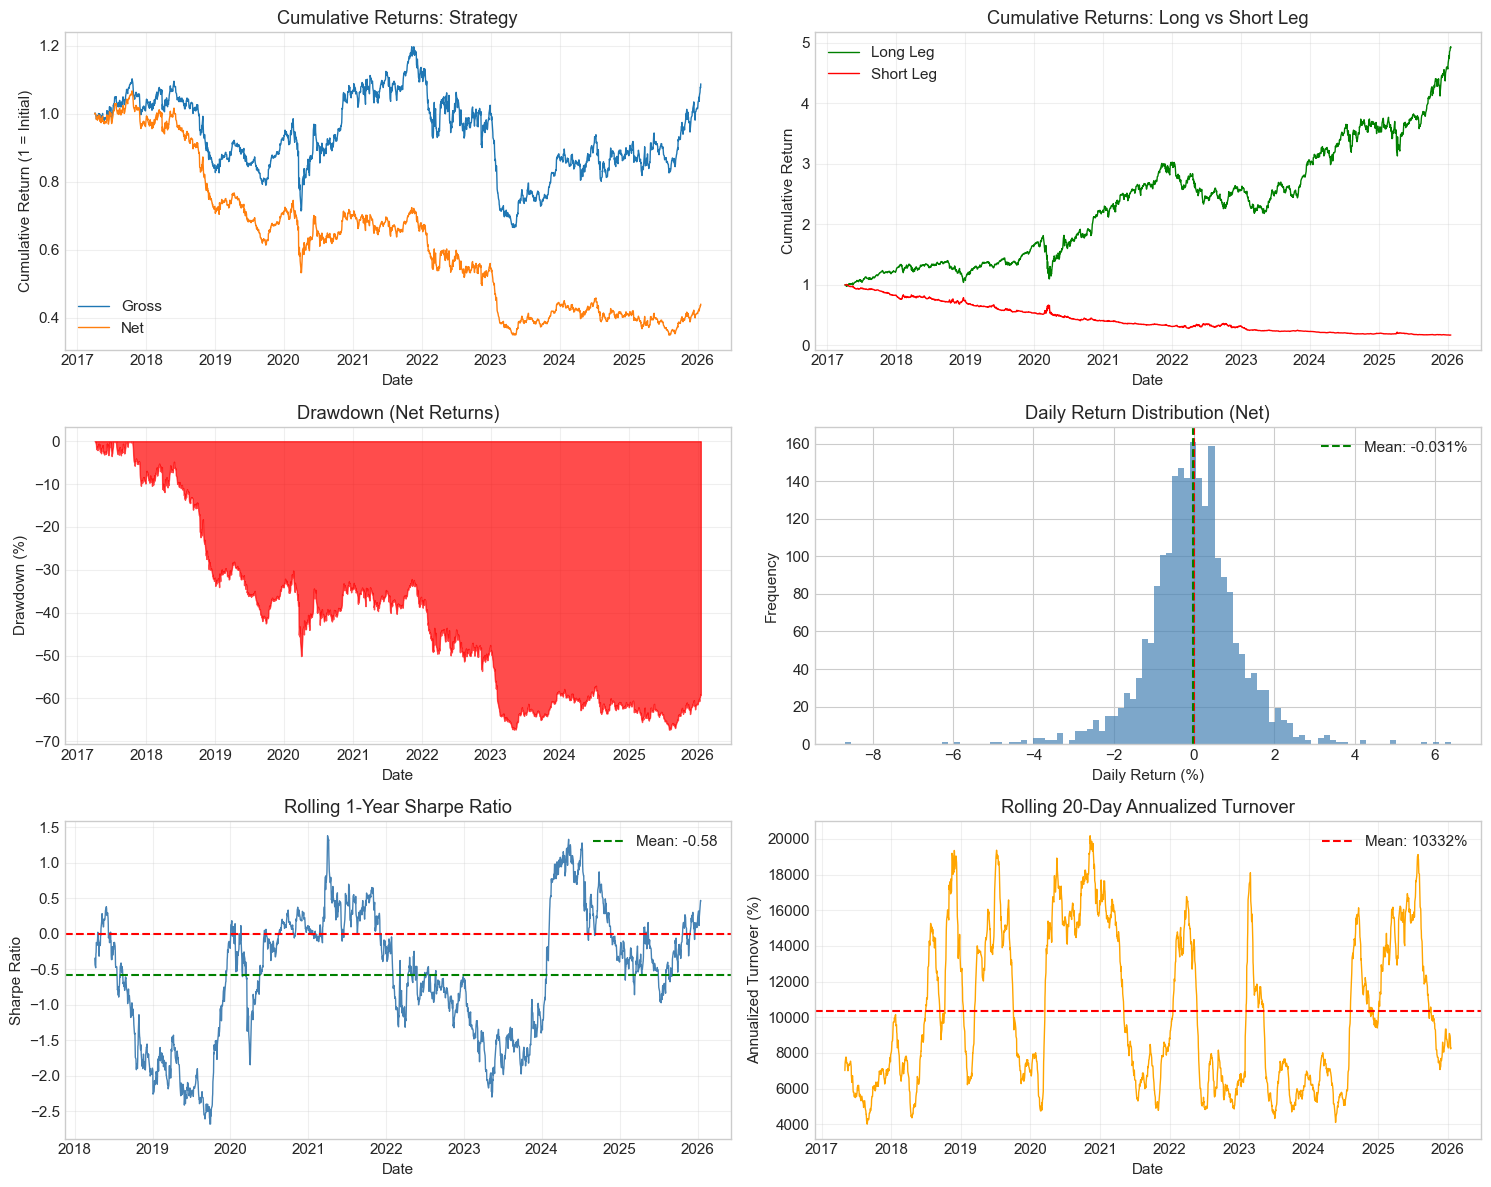

In [30]:
# =============================================================================
# EQUITY CURVE AND DRAWDOWN VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Cumulative returns
ax = axes[0, 0]
gross_cum = (1 + backtest_results['gross_returns']).cumprod()
net_cum = (1 + backtest_results['net_returns']).cumprod()
ax.plot(gross_cum.index, gross_cum, label='Gross', linewidth=1)
ax.plot(net_cum.index, net_cum, label='Net', linewidth=1)
ax.set_title('Cumulative Returns: Strategy')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (1 = Initial)')
ax.legend()
ax.grid(True, alpha=0.3)

# Long vs Short cumulative
ax = axes[0, 1]
long_cum = (1 + backtest_results['long_returns']).cumprod()
short_cum = (1 + backtest_results['short_returns']).cumprod()
ax.plot(long_cum.index, long_cum, label='Long Leg', linewidth=1, color='green')
ax.plot(short_cum.index, short_cum, label='Short Leg', linewidth=1, color='red')
ax.set_title('Cumulative Returns: Long vs Short Leg')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

# Drawdown
ax = axes[1, 0]
ax.fill_between(net_dd.index, net_dd * 100, 0, alpha=0.7, color='red')
ax.set_title('Drawdown (Net Returns)')
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown (%)')
ax.grid(True, alpha=0.3)

# Daily returns distribution
ax = axes[1, 1]
ax.hist(backtest_results['net_returns'] * 100, bins=100, alpha=0.7, color='steelblue', edgecolor='none')
ax.axvline(0, color='red', linestyle='--')
ax.axvline(backtest_results['net_returns'].mean() * 100, color='green', linestyle='--', 
           label=f'Mean: {backtest_results["net_returns"].mean()*100:.3f}%')
ax.set_title('Daily Return Distribution (Net)')
ax.set_xlabel('Daily Return (%)')
ax.set_ylabel('Frequency')
ax.legend()

# Rolling Sharpe (1Y)
ax = axes[2, 0]
rolling_sharpe = backtest_results['net_returns'].rolling(252).apply(
    lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0
)
ax.plot(rolling_sharpe.index, rolling_sharpe, linewidth=1, color='steelblue')
ax.axhline(0, color='red', linestyle='--')
ax.axhline(rolling_sharpe.mean(), color='green', linestyle='--', 
           label=f'Mean: {rolling_sharpe.mean():.2f}')
ax.set_title('Rolling 1-Year Sharpe Ratio')
ax.set_xlabel('Date')
ax.set_ylabel('Sharpe Ratio')
ax.legend()
ax.grid(True, alpha=0.3)

# Turnover over time
ax = axes[2, 1]
rolling_turnover = backtest_results['turnover'].rolling(20).mean() * 252 * 100
ax.plot(rolling_turnover.index, rolling_turnover, linewidth=1, color='orange')
ax.axhline(rolling_turnover.mean(), color='red', linestyle='--',
           label=f'Mean: {rolling_turnover.mean():.0f}%')
ax.set_title('Rolling 20-Day Annualized Turnover')
ax.set_xlabel('Date')
ax.set_ylabel('Annualized Turnover (%)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/baseline/04_performance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 10. Diagnostic Analysis

### Performance by Market Regime

We evaluate strategy performance conditional on:
1. **Volatility regime**: High vs. Low market volatility periods
2. **Dispersion regime**: High vs. Low cross-sectional return dispersion
3. **Market return**: Up vs. Down market days

In [31]:
# =============================================================================
# REGIME CONDITIONAL ANALYSIS
# =============================================================================

# Compute market metrics
market_return = panel['returns'].mean(axis=1)
market_vol = market_return.rolling(20).std() * np.sqrt(252)
cross_sectional_dispersion = panel['returns'].std(axis=1)

# Align with backtest results
common_idx = backtest_results['net_returns'].index
market_return_aligned = market_return.loc[common_idx]
market_vol_aligned = market_vol.loc[common_idx]
dispersion_aligned = cross_sectional_dispersion.loc[common_idx]

# Define regimes
vol_median = market_vol_aligned.median()
high_vol_mask = market_vol_aligned > vol_median

disp_median = dispersion_aligned.median()
high_disp_mask = dispersion_aligned > disp_median

up_market_mask = market_return_aligned > 0

# Compute conditional performance
def regime_stats(returns, mask, name):
    r = returns[mask]
    ann_ret = r.mean() * 252 * 100
    ann_vol = r.std() * np.sqrt(252) * 100
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    return {'Regime': name, 'N Days': mask.sum(), 'Ann Return (%)': ann_ret, 
            'Ann Vol (%)': ann_vol, 'Sharpe': sharpe}

regime_results = []
net_returns = backtest_results['net_returns']

regime_results.append(regime_stats(net_returns, high_vol_mask, 'High Volatility'))
regime_results.append(regime_stats(net_returns, ~high_vol_mask, 'Low Volatility'))
regime_results.append(regime_stats(net_returns, high_disp_mask, 'High Dispersion'))
regime_results.append(regime_stats(net_returns, ~high_disp_mask, 'Low Dispersion'))
regime_results.append(regime_stats(net_returns, up_market_mask, 'Up Market'))
regime_results.append(regime_stats(net_returns, ~up_market_mask, 'Down Market'))

regime_df = pd.DataFrame(regime_results)

print("Performance by Market Regime:")
print("=" * 80)
print(regime_df.to_string(index=False))

Performance by Market Regime:
         Regime  N Days  Ann Return (%)  Ann Vol (%)    Sharpe
High Volatility    1104       -6.395367    21.416255 -0.298622
 Low Volatility    1105       -9.066480    13.725223 -0.660571
High Dispersion    1104       -6.036470    23.144511 -0.260816
 Low Dispersion    1105       -9.425053    10.556064 -0.892857
      Up Market    1232       30.796369    18.217564  1.690477
    Down Market     977      -56.315325    17.205799 -3.273043


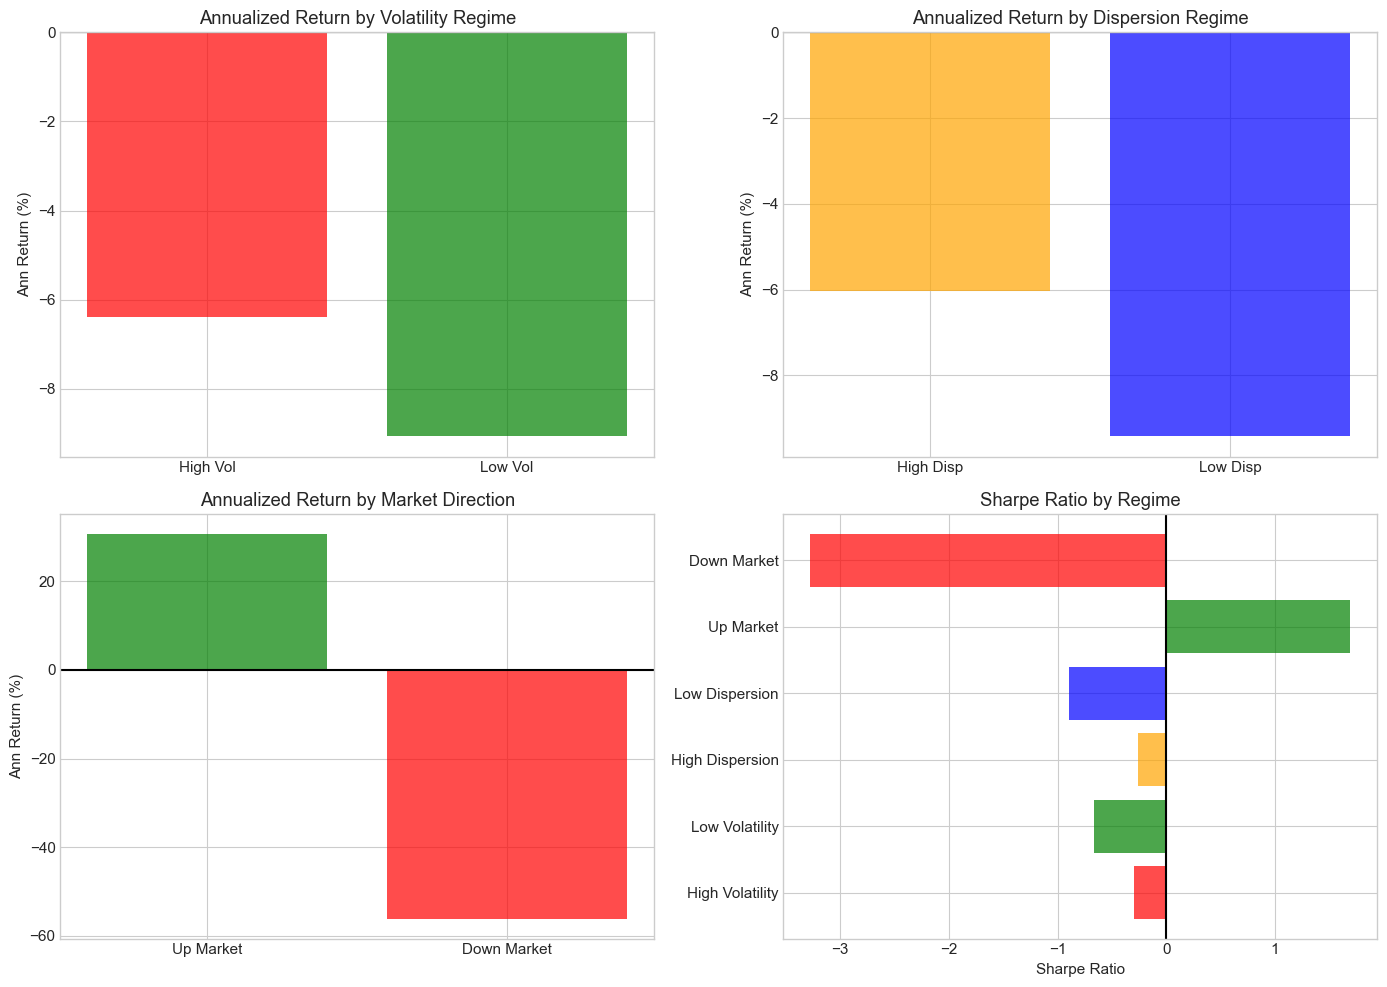

In [32]:
# =============================================================================
# REGIME VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Performance by volatility regime
ax = axes[0, 0]
high_vol_cum = (1 + net_returns[high_vol_mask]).cumprod()
low_vol_cum = (1 + net_returns[~high_vol_mask]).cumprod()
ax.bar(['High Vol', 'Low Vol'], 
       [regime_df[regime_df['Regime']=='High Volatility']['Ann Return (%)'].values[0],
        regime_df[regime_df['Regime']=='Low Volatility']['Ann Return (%)'].values[0]],
       color=['red', 'green'], alpha=0.7)
ax.axhline(0, color='black', linestyle='-')
ax.set_title('Annualized Return by Volatility Regime')
ax.set_ylabel('Ann Return (%)')

# Performance by dispersion regime
ax = axes[0, 1]
ax.bar(['High Disp', 'Low Disp'], 
       [regime_df[regime_df['Regime']=='High Dispersion']['Ann Return (%)'].values[0],
        regime_df[regime_df['Regime']=='Low Dispersion']['Ann Return (%)'].values[0]],
       color=['orange', 'blue'], alpha=0.7)
ax.axhline(0, color='black', linestyle='-')
ax.set_title('Annualized Return by Dispersion Regime')
ax.set_ylabel('Ann Return (%)')

# Performance by market direction
ax = axes[1, 0]
ax.bar(['Up Market', 'Down Market'], 
       [regime_df[regime_df['Regime']=='Up Market']['Ann Return (%)'].values[0],
        regime_df[regime_df['Regime']=='Down Market']['Ann Return (%)'].values[0]],
       color=['green', 'red'], alpha=0.7)
ax.axhline(0, color='black', linestyle='-')
ax.set_title('Annualized Return by Market Direction')
ax.set_ylabel('Ann Return (%)')

# Sharpe comparison
ax = axes[1, 1]
regimes = regime_df['Regime'].tolist()
sharpes = regime_df['Sharpe'].tolist()
colors = ['red', 'green', 'orange', 'blue', 'green', 'red']
ax.barh(regimes, sharpes, color=colors, alpha=0.7)
ax.axvline(0, color='black', linestyle='-')
ax.set_title('Sharpe Ratio by Regime')
ax.set_xlabel('Sharpe Ratio')

plt.tight_layout()
plt.savefig('../outputs/figures/baseline/05_regime_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

Yearly Performance (Net Returns):
 Year  Return (%)  Volatility (%)    Sharpe  Max DD (%)   Turnover  N Days
 2017   -3.769353       10.099978 -0.462315  -10.378521  46.773810     187
 2018  -24.359610       14.415137 -1.871429  -29.223639 108.100000     251
 2019   -3.121838       11.978020 -0.205062  -20.026882 115.297619     252
 2020   -0.569759       24.861963  0.101267  -28.570860 148.919048     253
 2021   -5.719820       16.180863 -0.283531  -10.770851  95.821429     252
 2022  -17.676324       25.144908 -0.650480  -26.562450  89.847619     251
 2023  -18.992245       16.055151 -1.241502  -36.087968  78.685714     250
 2024   -8.114906       17.409893 -0.399064  -15.306270  87.933333     252
 2025    2.076773       18.305340  0.204654  -17.149544 128.597619     250


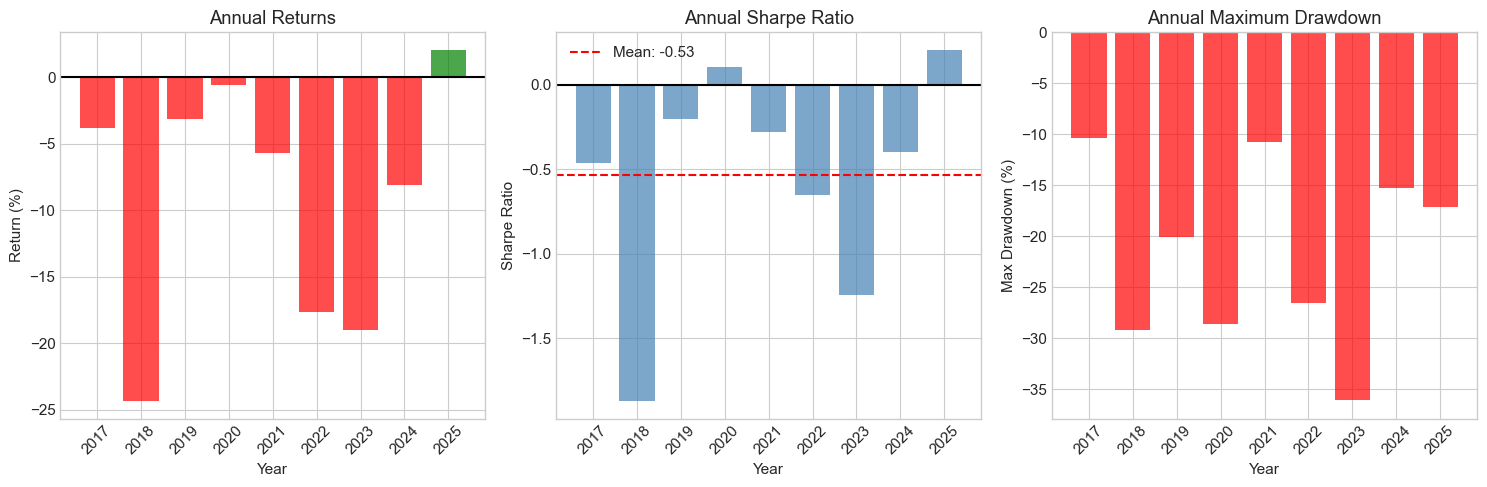

In [33]:
# =============================================================================
# YEARLY PERFORMANCE BREAKDOWN
# =============================================================================

def compute_yearly_metrics(returns, turnover):
    """Compute performance metrics by calendar year."""
    yearly = []
    
    for year in returns.index.year.unique():
        mask = returns.index.year == year
        r = returns[mask]
        to = turnover[mask]
        
        if len(r) < 20:  # Skip partial years
            continue
            
        total_ret = (1 + r).prod() - 1
        ann_vol = r.std() * np.sqrt(252)
        sharpe = (r.mean() * 252) / ann_vol if ann_vol > 0 else 0
        max_dd = ((1 + r).cumprod() / (1 + r).cumprod().expanding().max() - 1).min()
        
        yearly.append({
            'Year': year,
            'Return (%)': total_ret * 100,
            'Volatility (%)': ann_vol * 100,
            'Sharpe': sharpe,
            'Max DD (%)': max_dd * 100,
            'Turnover': to.sum(),
            'N Days': len(r)
        })
    
    return pd.DataFrame(yearly)

yearly_perf = compute_yearly_metrics(backtest_results['net_returns'], backtest_results['turnover'])

print("Yearly Performance (Net Returns):")
print("=" * 90)
print(yearly_perf.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
colors = ['green' if r > 0 else 'red' for r in yearly_perf['Return (%)']]
ax.bar(yearly_perf['Year'].astype(str), yearly_perf['Return (%)'], color=colors, alpha=0.7)
ax.axhline(0, color='black', linestyle='-')
ax.set_title('Annual Returns')
ax.set_xlabel('Year')
ax.set_ylabel('Return (%)')
ax.tick_params(axis='x', rotation=45)

ax = axes[1]
ax.bar(yearly_perf['Year'].astype(str), yearly_perf['Sharpe'], color='steelblue', alpha=0.7)
ax.axhline(0, color='black', linestyle='-')
ax.axhline(yearly_perf['Sharpe'].mean(), color='red', linestyle='--', label=f'Mean: {yearly_perf["Sharpe"].mean():.2f}')
ax.set_title('Annual Sharpe Ratio')
ax.set_xlabel('Year')
ax.set_ylabel('Sharpe Ratio')
ax.legend()
ax.tick_params(axis='x', rotation=45)

ax = axes[2]
ax.bar(yearly_perf['Year'].astype(str), yearly_perf['Max DD (%)'], color='red', alpha=0.7)
ax.set_title('Annual Maximum Drawdown')
ax.set_xlabel('Year')
ax.set_ylabel('Max Drawdown (%)')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../outputs/figures/baseline/06_yearly_performance.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 11. Baseline Sanity Checks

We verify the baseline satisfies minimum requirements:

In [34]:
# =============================================================================
# SANITY CHECKS
# =============================================================================

print("Baseline Sanity Checks:")
print("=" * 70)

checks = []

# Check 1: Sharpe > 0?
sharpe_gross = gross_metrics['Sharpe Ratio']
sharpe_net = net_metrics['Sharpe Ratio']
checks.append({
    'Check': 'Gross Sharpe > 0?',
    'Value': f'{sharpe_gross:.3f}',
    'Pass': 'YES' if sharpe_gross > 0 else 'NO'
})
checks.append({
    'Check': 'Net Sharpe > 0?',
    'Value': f'{sharpe_net:.3f}',
    'Pass': 'YES' if sharpe_net > 0 else 'NO'
})

# Check 2: Survives transaction costs?
tc_drag = gross_metrics['Annual Return (%)'] - net_metrics['Annual Return (%)']
survives_tc = net_metrics['Annual Return (%)'] > 0
checks.append({
    'Check': 'Survives transaction costs?',
    'Value': f'{tc_drag:.2f}% drag',
    'Pass': 'YES' if survives_tc else 'NO'
})

# Check 3: Reasonable turnover?
ann_turnover = net_metrics['Annual Turnover']
reasonable_turnover = ann_turnover < 50  # Less than 50x annual turnover
checks.append({
    'Check': 'Reasonable turnover (< 50x)?',
    'Value': f'{ann_turnover:.1f}x',
    'Pass': 'YES' if reasonable_turnover else 'NO'
})

# Check 4: Max drawdown reasonable?
max_dd = net_metrics['Max Drawdown (%)']
reasonable_dd = max_dd > -50  # Less than 50% drawdown
checks.append({
    'Check': 'Max drawdown < 50%?',
    'Value': f'{max_dd:.1f}%',
    'Pass': 'YES' if reasonable_dd else 'NO'
})

# Check 5: Consistent across years?
positive_years = (yearly_perf['Return (%)'] > 0).sum()
total_years = len(yearly_perf)
checks.append({
    'Check': 'Positive years > 50%?',
    'Value': f'{positive_years}/{total_years}',
    'Pass': 'YES' if positive_years > total_years / 2 else 'NO'
})

# Check 6: Long leg beats short leg?
long_ret = long_metrics['Annual Return (%)']
short_ret = short_metrics['Annual Return (%)']
checks.append({
    'Check': 'Long leg > Short leg?',
    'Value': f'L:{long_ret:.1f}% S:{short_ret:.1f}%',
    'Pass': 'YES' if long_ret > short_ret else 'NO'
})

checks_df = pd.DataFrame(checks)
print(checks_df.to_string(index=False))

print("\n" + "=" * 70)
n_pass = (checks_df['Pass'] == 'YES').sum()
print(f"Summary: {n_pass}/{len(checks)} checks passed")

Baseline Sanity Checks:
                       Check            Value Pass
           Gross Sharpe > 0?            0.144  YES
             Net Sharpe > 0?           -0.430   NO
 Survives transaction costs?      10.31% drag   NO
Reasonable turnover (< 50x)?           103.1x   NO
         Max drawdown < 50%?           -67.3%   NO
       Positive years > 50%?              1/9   NO
       Long leg > Short leg? L:20.7% S:-18.1%  YES

Summary: 2/7 checks passed


---

## 12. Strategy vs Benchmark Comparison

Strategy vs Equal-Weight Benchmark:
Metric                          Strategy (Net)    EW Benchmark
----------------------------------------------------------------------
Annual Return (%)                        -7.73           18.75
Annual Volatility (%)                    17.98           18.21
Sharpe Ratio                             -0.43            1.03
Max Drawdown (%)                        -67.29          -33.41
Total Return (%)                        -55.95          347.07


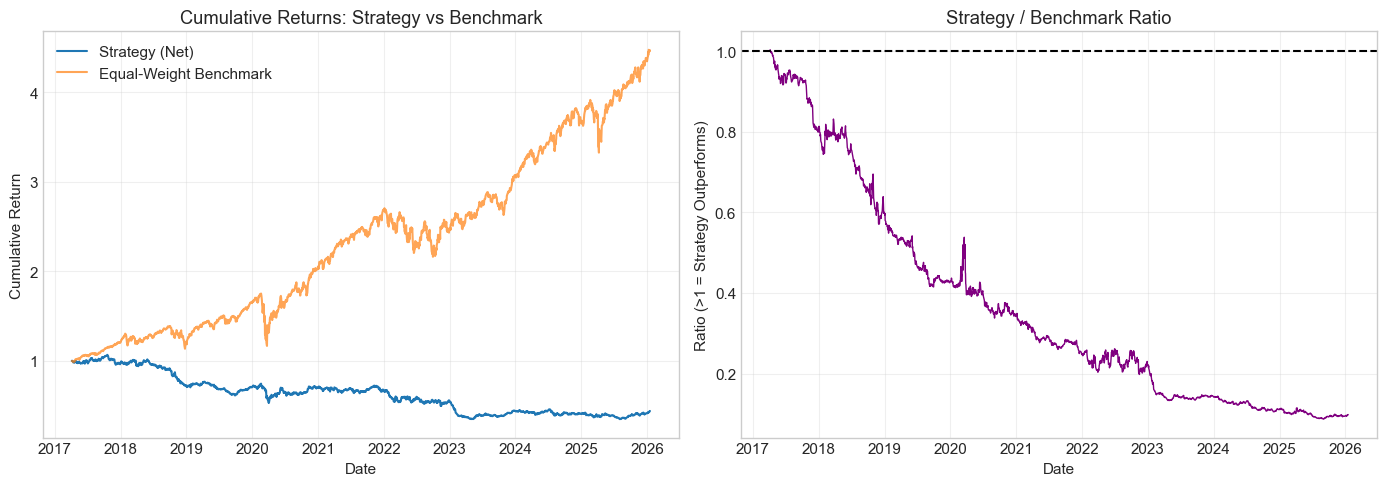

In [35]:
# =============================================================================
# BENCHMARK COMPARISON: EQUAL-WEIGHT BUY-AND-HOLD
# =============================================================================

# Equal-weight benchmark (long only)
ew_returns = panel['returns'].mean(axis=1)
ew_returns_aligned = ew_returns.loc[backtest_results['net_returns'].index]

ew_metrics, ew_dd = compute_performance_metrics(
    ew_returns_aligned,
    pd.Series(0, index=ew_returns_aligned.index),  # No turnover
    PARAMS['trading_days_per_year']
)

print("Strategy vs Equal-Weight Benchmark:")
print("=" * 70)
print(f"{'Metric':<30} {'Strategy (Net)':>15} {'EW Benchmark':>15}")
print("-" * 70)
for metric in ['Annual Return (%)', 'Annual Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Total Return (%)']:
    strat_val = net_metrics[metric]
    ew_val = ew_metrics[metric]
    print(f"{metric:<30} {strat_val:>15.2f} {ew_val:>15.2f}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
strat_cum = (1 + backtest_results['net_returns']).cumprod()
ew_cum = (1 + ew_returns_aligned).cumprod()
ax.plot(strat_cum.index, strat_cum, label='Strategy (Net)', linewidth=1.5)
ax.plot(ew_cum.index, ew_cum, label='Equal-Weight Benchmark', linewidth=1.5, alpha=0.7)
ax.set_title('Cumulative Returns: Strategy vs Benchmark')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
# Strategy-benchmark spread
spread = strat_cum / ew_cum
ax.plot(spread.index, spread, color='purple', linewidth=1)
ax.axhline(1, color='black', linestyle='--')
ax.set_title('Strategy / Benchmark Ratio')
ax.set_xlabel('Date')
ax.set_ylabel('Ratio (>1 = Strategy Outperforms)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/baseline/07_benchmark_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 13. Why This Baseline Is Intentionally Weak

This baseline is **designed to be weak**. Its purpose is not to generate alpha, but to serve as a clean measurement instrument.

### Known Weaknesses

| Weakness | Explanation |
|----------|-------------|
| **No regime conditioning** | The model treats all market conditions identically, despite evidence that momentum behaves differently in high vs. low volatility regimes |
| **Fixed lookback windows** | 5-day and 20-day windows are arbitrary; adaptive windows would likely improve performance |
| **No feature interactions** | Linear model cannot capture non-linear relationships between features and returns |
| **Equal weighting** | All assets receive equal weight within each leg, ignoring volatility or liquidity differences |
| **No volume information** | Trading volume is known to contain predictive information, but is excluded |
| **No sector/industry structure** | Cross-asset correlation structure is ignored |
| **Daily rebalancing** | Generates high turnover; less frequent rebalancing would reduce costs |
| **Fixed regularization** | No hyperparameter tuning means the model is likely suboptimal |

### Why These Weaknesses Are Features, Not Bugs

1. **Interpretability**: Every component of the baseline is transparent and explainable
2. **Stability**: Simple models are less prone to overfitting and regime change
3. **Baseline comparability**: Future improvements can be cleanly attributed to specific changes
4. **Reproducibility**: No random seeds in model training, no complex hyperparameter searches

In [36]:
# =============================================================================
# SAVE RESULTS
# =============================================================================

import json
import os

# Create output directory
os.makedirs('../outputs/baseline', exist_ok=True)

# Save metrics
metrics_output = {
    'gross_metrics': {k: float(v) if isinstance(v, (np.floating, float)) else int(v) for k, v in gross_metrics.items()},
    'net_metrics': {k: float(v) if isinstance(v, (np.floating, float)) else int(v) for k, v in net_metrics.items()},
    'long_metrics': {k: float(v) if isinstance(v, (np.floating, float)) else int(v) for k, v in long_metrics.items()},
    'short_metrics': {k: float(v) if isinstance(v, (np.floating, float)) else int(v) for k, v in short_metrics.items()},
    'benchmark_metrics': {k: float(v) if isinstance(v, (np.floating, float)) else int(v) for k, v in ew_metrics.items()},
    'parameters': PARAMS,
}

with open('../outputs/baseline/baseline_metrics.json', 'w') as f:
    json.dump(metrics_output, f, indent=2)

# Save predictions and weights for future analysis
predictions.to_parquet('../outputs/baseline/predictions.parquet')
weights.to_parquet('../outputs/baseline/weights.parquet')
coefficients.to_parquet('../outputs/baseline/coefficients.parquet')

# Save daily returns
returns_output = pd.DataFrame({
    'gross_returns': backtest_results['gross_returns'],
    'net_returns': backtest_results['net_returns'],
    'long_returns': backtest_results['long_returns'],
    'short_returns': backtest_results['short_returns'],
    'turnover': backtest_results['turnover'],
    'transaction_costs': backtest_results['transaction_costs'],
})
returns_output.to_parquet('../outputs/baseline/daily_returns.parquet')

print("Results saved to ../outputs/baseline/")
print("  - baseline_metrics.json")
print("  - predictions.parquet")
print("  - weights.parquet")
print("  - coefficients.parquet")
print("  - daily_returns.parquet")

Results saved to ../outputs/baseline/
  - baseline_metrics.json
  - predictions.parquet
  - weights.parquet
  - coefficients.parquet
  - daily_returns.parquet


---

## 14. Scientific Usage of This Baseline

### How This Baseline Will Be Used

1. **Control experiment**: All future features and modeling improvements are evaluated as incremental changes relative to this baseline

2. **One-at-a-time testing**: New features are added individually, and performance is compared:
   - If feature improves out-of-sample Sharpe by > 0.1 with statistical significance, it is retained
   - If feature improves in-sample but degrades out-of-sample, it is **discarded**

3. **Robustness requirements**: Improvements must be:
   - **Consistent**: Hold across multiple time periods
   - **Robust**: Survive reasonable parameter perturbations
   - **Explainable**: Have economic intuition

4. **Documentation**: All experiments (successful and failed) are logged with:
   - Feature specification
   - Performance delta vs. baseline
   - Hypothesis for why the feature worked/failed

### Metrics for Incremental Evaluation

| Metric | Baseline Value | Improvement Threshold |
|--------|---------------|----------------------|
| Sharpe Ratio | (recorded above) | +0.10 |
| Max Drawdown | (recorded above) | -20% relative |
| Turnover | (recorded above) | No increase |

### What Does Not Count as Improvement

- In-sample performance gains that disappear out-of-sample
- Improvements that require unrealistic assumptions (zero transaction costs, perfect execution)
- Black-box models that cannot be explained
- Improvements that increase turnover disproportionately

In [38]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("\n" + "=" * 80)
print("BASELINE PIPELINE SUMMARY")
print("=" * 80)

print("\n1. PROBLEM FORMULATION")
print("   - Target: Cross-sectional relative returns")
print("   - Universe: 100 S&P 500 constituents")
print(f"   - Period: {backtest_results['net_returns'].index[0].date()} to {backtest_results['net_returns'].index[-1].date()}")

print("\n2. FEATURES (3 total)")
print("   - f1: Short-term volatility-normalized momentum (5d / 20d vol)")
print("   - f2: Medium-term cumulative return (20d)")
print("   - f3: Realized volatility (20d)")

print("\n3. MODEL")
print(f"   - Ridge Regression (alpha = {PARAMS['ridge_alpha']})")
print(f"   - Rolling window: {PARAMS['training_window']} days")
print("   - Cross-sectional training")

print("\n4. PORTFOLIO")
print(f"   - Long: Top {PARAMS['long_pct']*100:.0f}% by signal")
print(f"   - Short: Bottom {PARAMS['short_pct']*100:.0f}% by signal")
print("   - Equal weight, dollar neutral")

print("\n5. KEY METRICS (Net of 10bps transaction costs)")
print(f"   - Annual Return:     {net_metrics['Annual Return (%)']:.2f}%")
print(f"   - Annual Volatility: {net_metrics['Annual Volatility (%)']:.2f}%")
print(f"   - Sharpe Ratio:      {net_metrics['Sharpe Ratio']:.3f}")
print(f"   - Max Drawdown:      {net_metrics['Max Drawdown (%)']:.2f}%")
print(f"   - Annual Turnover:   {net_metrics['Annual Turnover']:.1f}x")

print("\n6. STATUS")
sharpe_status = "POSITIVE" if net_metrics['Sharpe Ratio'] > 0 else "NEGATIVE"
print(f"   - Sharpe > 0: {sharpe_status}")
print(f"   - Survives TC: {'YES' if net_metrics['Annual Return (%)'] > 0 else 'NO'}")
print(f"   - Benchmark comparison: {'OUTPERFORMS' if net_metrics['Sharpe Ratio'] > ew_metrics['Sharpe Ratio'] else 'UNDERPERFORMS'}")

print("\n" + "=" * 80)
print("This baseline is intentionally simple and weak.")
print("It serves as the control experiment for all future improvements.")
print("=" * 80)


BASELINE PIPELINE SUMMARY

1. PROBLEM FORMULATION
   - Target: Cross-sectional relative returns
   - Universe: 100 S&P 500 constituents
   - Period: 2017-04-05 to 2026-01-16

2. FEATURES (3 total)
   - f1: Short-term volatility-normalized momentum (5d / 20d vol)
   - f2: Medium-term cumulative return (20d)
   - f3: Realized volatility (20d)

3. MODEL
   - Ridge Regression (alpha = 1.0)
   - Rolling window: 252 days
   - Cross-sectional training

4. PORTFOLIO
   - Long: Top 20% by signal
   - Short: Bottom 20% by signal
   - Equal weight, dollar neutral

5. KEY METRICS (Net of 10bps transaction costs)
   - Annual Return:     -7.73%
   - Annual Volatility: 17.98%
   - Sharpe Ratio:      -0.430
   - Max Drawdown:      -67.29%
   - Annual Turnover:   103.1x

6. STATUS
   - Sharpe > 0: NEGATIVE
   - Survives TC: NO
   - Benchmark comparison: UNDERPERFORMS

This baseline is intentionally simple and weak.
It serves as the control experiment for all future improvements.


---

## Appendix: Design Decisions and Justifications

### A.1 Why Cross-Sectional Regression?

Cross-sectional regression pools all assets at each time point, treating relative performance as the target. This approach:

1. Naturally produces dollar-neutral signals
2. Is robust to market-wide movements (beta neutrality by construction)
3. Aligns with the economic structure of long-short equity strategies

### A.2 Why Not Time-Series Prediction?

Time-series models for individual assets would:
- Require 100 separate models (one per asset)
- Be susceptible to overfitting on individual asset histories
- Produce signals that are not naturally dollar-neutral

### A.3 Why Ridge Regression?

Ridge regression was chosen for:
- **Simplicity**: Closed-form solution, no iteration
- **Regularization**: Prevents coefficient explosion with correlated features
- **Interpretability**: Linear coefficients have direct economic interpretation

### A.4 Why Fixed Regularization?

Hyperparameter tuning was avoided because:
- It introduces additional degrees of freedom that can lead to overfitting
- Cross-validation in time-series data is methodologically challenging
- A baseline should be maximally simple and reproducible

### A.5 Why 10 bps Transaction Costs?

10 basis points (0.10%) is a reasonable estimate for:
- Bid-ask spread: ~2-5 bps for liquid large-caps
- Market impact: ~3-5 bps for moderate position sizes
- Commission: ~1-2 bps at institutional rates

This is conservative for a well-executed strategy but realistic for a baseline.

### A.6 Why Daily Rebalancing?

Daily rebalancing was chosen for simplicity, despite generating high turnover. In practice:
- Less frequent rebalancing would reduce turnover and improve net returns
- This is a known area for future improvement
- The baseline intentionally does not optimize rebalancing frequency